# Q-learning

Importing the libraries that are needed

In [ ]:
import gymnasium as gym
import numpy as np

Creating the environment

In [85]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

Assign the variables for the algorithm

In [86]:
numberEpisodes=15000 

#shaping the Q-values table
actionNumber=env.action_space.n #how many actions at each state
numberOfBinsPosition=30
numberOfBinsVelocity=30
numberOfBinsAngle=30
numberOfBinsAngleVelocity=30
numberOfBins=[numberOfBinsPosition,numberOfBinsVelocity,numberOfBinsAngle,numberOfBinsAngleVelocity]

#assigning the limits of each index in the observation
upperBounds=env.observation_space.high
lowerBounds=env.observation_space.low
cartVelocityMin=-3
cartVelocityMax=3
poleAngleVelocityMin=-10
poleAngleVelocityMax=10
upperBounds[1]=cartVelocityMax
upperBounds[3]=poleAngleVelocityMax
lowerBounds[1]=cartVelocityMin
lowerBounds[3]=poleAngleVelocityMin

#rewards of each episode
sumRewardsEpisode=[]

#defining Qmatrix
Qmatrix=np.random.uniform(low=0, high=1, size=(numberOfBins[0],numberOfBins[1],numberOfBins[2],numberOfBins[3],actionNumber))


Since the states (observations) in the cart-pole environment are continuous it is needed to discretizise the states. That is why for each variable of observation we have a number of bins, which will be the number of sections from that variable.

In [87]:
def returnIndexState(state):
        position =      state[0]
        velocity =      state[1]
        angle    =      state[2]
        angularVelocity=state[3]
         
        cartPositionBin=np.linspace(lowerBounds[0],upperBounds[0],numberOfBins[0])
        cartVelocityBin=np.linspace(lowerBounds[1],upperBounds[1],numberOfBins[1])
        poleAngleBin=np.linspace(lowerBounds[2],upperBounds[2],numberOfBins[2])
        poleAngleVelocityBin=np.linspace(lowerBounds[3],upperBounds[3],numberOfBins[3])
         
        indexPosition=np.maximum(np.digitize(state[0],cartPositionBin)-1,0)
        indexVelocity=np.maximum(np.digitize(state[1],cartVelocityBin)-1,0)
        indexAngle=np.maximum(np.digitize(state[2],poleAngleBin)-1,0)
        indexAngularVelocity=np.maximum(np.digitize(state[3],poleAngleVelocityBin)-1,0)
         
        return tuple([indexPosition,indexVelocity,indexAngle,indexAngularVelocity])  

The process of selecting an action will consist in tghree parts pure exploration,learning and exploiting

In [88]:
 def selectAction(state,index,epsilon):
         
        # first 500 episodes we select completely random actions to have enough exploration
        if index<500:
            return np.random.choice(actionNumber),epsilon   
             
        # Returns a random real number in the half-open interval [0.0, 1.0)
        # this number is used for the epsilon greedy approach
        randomNumber=np.random.random()
         
        # after 7000 episodes, we slowly start to decrease the epsilon parameter
        if index>7000:
            epsilon2=0.999*epsilon
        else:
            epsilon2=epsilon
        # if this condition is satisfied, we are exploring, that is, we select random actions
        if randomNumber < epsilon:
            # returns a random action selected from: 0,1,...,actionNumber-1
            return np.random.choice(actionNumber),epsilon2            
         
        # otherwise, we are selecting greedy actions
        else:
            # we return the index where Qmatrix[state,:] has the max value
            # that is, since the index denotes an action, we select greedy actions
            return np.random.choice(np.where(Qmatrix[returnIndexState(state)]==np.max(Qmatrix[returnIndexState(state)]))[0]),epsilon2
            # here we need to return the minimum index since it can happen
            # that there are several identical maximal entries, for example 
            # import numpy as np
            # a=[0,1,1,0]
            # np.where(a==np.max(a))
            # this will return [1,2], but we only need a single index
            # that is why we need to have np.random.choice(np.where(a==np.max(a))[0])
            # note that zero has to be added here since np.where() returns a tuple
    ###########################################################################
    #    END - function selecting an action: epsilon-greedy approach
    ###########################################################################

Training

In [89]:
def simulateEpisodes():
        #inputs for Q-learning
        epsilon = 0.1 #learing
        alpha = 1 #step
        gamma = 0.9 #discount rate
        # here we loop through the episodes
        for indexEpisode in range(numberEpisodes):
             
            # list that stores rewards per episode - this is necessary for keeping track of convergence 
            rewardsEpisode=[]
             
            # reset the environment at the beginning of every episode
            (stateS,_)=env.reset()
            stateS=list(stateS)
           
            print("Simulating episode {}".format(indexEpisode))
             
             
            # here we step from one state to another
            # this will loop until a terminal state is reached
            terminalState=False
            while not terminalState:
                # return a discretized index of the state
                 
                stateSIndex=returnIndexState(stateS)
                 
                # select an action on the basis of the current state, denoted by stateS
                actionA,epsilon = selectAction(stateS,indexEpisode,epsilon)
                 
                 
                # here we step and return the state, reward, and boolean denoting if the state is a terminal state
                # prime means that it is the next state
                (stateSprime, reward, terminalState,_,_) = env.step(actionA)          
                 
                rewardsEpisode.append(reward)
                 
                stateSprime=list(stateSprime)
                 
                stateSprimeIndex=returnIndexState(stateSprime)
                 
                # return the max value, we do not need actionAprime...
                QmaxPrime=np.max(Qmatrix[stateSprimeIndex])                                               
                                              
                if not terminalState:
                    # stateS+(actionA,) - we use this notation to append the tuples
                    # for example, for stateS=(0,0,0,1) and actionA=(1,0)
                    # we have stateS+(actionA,)=(0,0,0,1,0)
                    error=reward+gamma*QmaxPrime-Qmatrix[stateSIndex+(actionA,)]
                    Qmatrix[stateSIndex+(actionA,)]=Qmatrix[stateSIndex+(actionA,)]+alpha*error
                else:
                    # in the terminal state, we have Qmatrix[stateSprime,actionAprime]=0 
                    error=reward-Qmatrix[stateSIndex+(actionA,)]
                    Qmatrix[stateSIndex+(actionA,)]=Qmatrix[stateSIndex+(actionA,)]+alpha*error
                 
                # set the current state to the next state                    
                stateS=stateSprime
         
            print("Sum of rewards {}".format(np.sum(rewardsEpisode)))        
            sumRewardsEpisode.append(np.sum(rewardsEpisode))

Once is trained exploit

In [90]:
import time

def simulateLearnedStrategy():
        (currentState,_)=env.reset()
        env.render()
        timeSteps=1000
        # obtained rewards at every time step
        obtainedRewards=[]
         
        for timeIndex in range(timeSteps):
            print(timeIndex)
            # select greedy actions
            actionInStateS=np.random.choice(np.where(Qmatrix[returnIndexState(currentState)]==np.max(Qmatrix[returnIndexState(currentState)]))[0])
            currentState, reward, terminated, truncated, info =env.step(actionInStateS)
            obtainedRewards.append(reward)   
            time.sleep(0.05)
            if (terminated):
                time.sleep(1)
                break
        return obtainedRewards,env

In [91]:
simulateEpisodes()


Simulating episode 0
Sum of rewards 11.0
Simulating episode 1
Sum of rewards 12.0
Simulating episode 2
Sum of rewards 17.0
Simulating episode 3
Sum of rewards 20.0
Simulating episode 4
Sum of rewards 17.0
Simulating episode 5
Sum of rewards 16.0
Simulating episode 6
Sum of rewards 12.0
Simulating episode 7
Sum of rewards 16.0
Simulating episode 8
Sum of rewards 13.0
Simulating episode 9
Sum of rewards 16.0
Simulating episode 10
Sum of rewards 33.0
Simulating episode 11
Sum of rewards 25.0
Simulating episode 12
Sum of rewards 19.0
Simulating episode 13
Sum of rewards 14.0
Simulating episode 14
Sum of rewards 14.0
Simulating episode 15
Sum of rewards 15.0
Simulating episode 16
Sum of rewards 25.0
Simulating episode 17
Sum of rewards 23.0
Simulating episode 18
Sum of rewards 19.0
Simulating episode 19
Sum of rewards 38.0
Simulating episode 20
Sum of rewards 25.0
Simulating episode 21
Sum of rewards 24.0
Simulating episode 22
Sum of rewards 14.0
Simulating episode 23
Sum of rewards 50.0
Si

Sum of rewards 27.0
Simulating episode 212
Sum of rewards 15.0
Simulating episode 213
Sum of rewards 43.0
Simulating episode 214
Sum of rewards 111.0
Simulating episode 215
Sum of rewards 32.0
Simulating episode 216
Sum of rewards 38.0
Simulating episode 217
Sum of rewards 20.0
Simulating episode 218
Sum of rewards 13.0
Simulating episode 219
Sum of rewards 23.0
Simulating episode 220
Sum of rewards 14.0
Simulating episode 221
Sum of rewards 40.0
Simulating episode 222
Sum of rewards 32.0
Simulating episode 223
Sum of rewards 13.0
Simulating episode 224
Sum of rewards 16.0
Simulating episode 225
Sum of rewards 9.0
Simulating episode 226
Sum of rewards 36.0
Simulating episode 227
Sum of rewards 29.0
Simulating episode 228
Sum of rewards 25.0
Simulating episode 229
Sum of rewards 33.0
Simulating episode 230
Sum of rewards 34.0
Simulating episode 231
Sum of rewards 11.0
Simulating episode 232
Sum of rewards 10.0
Simulating episode 233
Sum of rewards 8.0
Simulating episode 234
Sum of rewar

Sum of rewards 24.0
Simulating episode 426
Sum of rewards 23.0
Simulating episode 427
Sum of rewards 37.0
Simulating episode 428
Sum of rewards 15.0
Simulating episode 429
Sum of rewards 12.0
Simulating episode 430
Sum of rewards 13.0
Simulating episode 431
Sum of rewards 24.0
Simulating episode 432
Sum of rewards 15.0
Simulating episode 433
Sum of rewards 15.0
Simulating episode 434
Sum of rewards 17.0
Simulating episode 435
Sum of rewards 14.0
Simulating episode 436
Sum of rewards 13.0
Simulating episode 437
Sum of rewards 19.0
Simulating episode 438
Sum of rewards 13.0
Simulating episode 439
Sum of rewards 11.0
Simulating episode 440
Sum of rewards 37.0
Simulating episode 441
Sum of rewards 11.0
Simulating episode 442
Sum of rewards 18.0
Simulating episode 443
Sum of rewards 16.0
Simulating episode 444
Sum of rewards 11.0
Simulating episode 445
Sum of rewards 26.0
Simulating episode 446
Sum of rewards 12.0
Simulating episode 447
Sum of rewards 26.0
Simulating episode 448
Sum of rewa

Sum of rewards 42.0
Simulating episode 617
Sum of rewards 29.0
Simulating episode 618
Sum of rewards 76.0
Simulating episode 619
Sum of rewards 31.0
Simulating episode 620
Sum of rewards 49.0
Simulating episode 621
Sum of rewards 114.0
Simulating episode 622
Sum of rewards 41.0
Simulating episode 623
Sum of rewards 39.0
Simulating episode 624
Sum of rewards 11.0
Simulating episode 625
Sum of rewards 76.0
Simulating episode 626
Sum of rewards 35.0
Simulating episode 627
Sum of rewards 112.0
Simulating episode 628
Sum of rewards 107.0
Simulating episode 629
Sum of rewards 45.0
Simulating episode 630
Sum of rewards 51.0
Simulating episode 631
Sum of rewards 76.0
Simulating episode 632
Sum of rewards 47.0
Simulating episode 633
Sum of rewards 41.0
Simulating episode 634
Sum of rewards 15.0
Simulating episode 635
Sum of rewards 71.0
Simulating episode 636
Sum of rewards 22.0
Simulating episode 637
Sum of rewards 19.0
Simulating episode 638
Sum of rewards 77.0
Simulating episode 639
Sum of r

Sum of rewards 69.0
Simulating episode 813
Sum of rewards 75.0
Simulating episode 814
Sum of rewards 20.0
Simulating episode 815
Sum of rewards 20.0
Simulating episode 816
Sum of rewards 60.0
Simulating episode 817
Sum of rewards 19.0
Simulating episode 818
Sum of rewards 50.0
Simulating episode 819
Sum of rewards 41.0
Simulating episode 820
Sum of rewards 68.0
Simulating episode 821
Sum of rewards 72.0
Simulating episode 822
Sum of rewards 58.0
Simulating episode 823
Sum of rewards 29.0
Simulating episode 824
Sum of rewards 74.0
Simulating episode 825
Sum of rewards 58.0
Simulating episode 826
Sum of rewards 44.0
Simulating episode 827
Sum of rewards 43.0
Simulating episode 828
Sum of rewards 40.0
Simulating episode 829
Sum of rewards 36.0
Simulating episode 830
Sum of rewards 18.0
Simulating episode 831
Sum of rewards 31.0
Simulating episode 832
Sum of rewards 52.0
Simulating episode 833
Sum of rewards 67.0
Simulating episode 834
Sum of rewards 45.0
Simulating episode 835
Sum of rewa

Sum of rewards 89.0
Simulating episode 1005
Sum of rewards 65.0
Simulating episode 1006
Sum of rewards 63.0
Simulating episode 1007
Sum of rewards 39.0
Simulating episode 1008
Sum of rewards 76.0
Simulating episode 1009
Sum of rewards 60.0
Simulating episode 1010
Sum of rewards 60.0
Simulating episode 1011
Sum of rewards 92.0
Simulating episode 1012
Sum of rewards 85.0
Simulating episode 1013
Sum of rewards 28.0
Simulating episode 1014
Sum of rewards 106.0
Simulating episode 1015
Sum of rewards 72.0
Simulating episode 1016
Sum of rewards 29.0
Simulating episode 1017
Sum of rewards 68.0
Simulating episode 1018
Sum of rewards 73.0
Simulating episode 1019
Sum of rewards 87.0
Simulating episode 1020
Sum of rewards 70.0
Simulating episode 1021
Sum of rewards 19.0
Simulating episode 1022
Sum of rewards 89.0
Simulating episode 1023
Sum of rewards 68.0
Simulating episode 1024
Sum of rewards 51.0
Simulating episode 1025
Sum of rewards 45.0
Simulating episode 1026
Sum of rewards 30.0
Simulating 

Sum of rewards 102.0
Simulating episode 1196
Sum of rewards 73.0
Simulating episode 1197
Sum of rewards 35.0
Simulating episode 1198
Sum of rewards 42.0
Simulating episode 1199
Sum of rewards 48.0
Simulating episode 1200
Sum of rewards 36.0
Simulating episode 1201
Sum of rewards 58.0
Simulating episode 1202
Sum of rewards 104.0
Simulating episode 1203
Sum of rewards 61.0
Simulating episode 1204
Sum of rewards 61.0
Simulating episode 1205
Sum of rewards 41.0
Simulating episode 1206
Sum of rewards 64.0
Simulating episode 1207
Sum of rewards 86.0
Simulating episode 1208
Sum of rewards 57.0
Simulating episode 1209
Sum of rewards 66.0
Simulating episode 1210
Sum of rewards 94.0
Simulating episode 1211
Sum of rewards 43.0
Simulating episode 1212
Sum of rewards 67.0
Simulating episode 1213
Sum of rewards 52.0
Simulating episode 1214
Sum of rewards 37.0
Simulating episode 1215
Sum of rewards 33.0
Simulating episode 1216
Sum of rewards 85.0
Simulating episode 1217
Sum of rewards 106.0
Simulatin

Sum of rewards 38.0
Simulating episode 1391
Sum of rewards 51.0
Simulating episode 1392
Sum of rewards 43.0
Simulating episode 1393
Sum of rewards 74.0
Simulating episode 1394
Sum of rewards 18.0
Simulating episode 1395
Sum of rewards 37.0
Simulating episode 1396
Sum of rewards 63.0
Simulating episode 1397
Sum of rewards 97.0
Simulating episode 1398
Sum of rewards 66.0
Simulating episode 1399
Sum of rewards 90.0
Simulating episode 1400
Sum of rewards 129.0
Simulating episode 1401
Sum of rewards 76.0
Simulating episode 1402
Sum of rewards 41.0
Simulating episode 1403
Sum of rewards 23.0
Simulating episode 1404
Sum of rewards 24.0
Simulating episode 1405
Sum of rewards 107.0
Simulating episode 1406
Sum of rewards 56.0
Simulating episode 1407
Sum of rewards 78.0
Simulating episode 1408
Sum of rewards 94.0
Simulating episode 1409
Sum of rewards 36.0
Simulating episode 1410
Sum of rewards 97.0
Simulating episode 1411
Sum of rewards 85.0
Simulating episode 1412
Sum of rewards 173.0
Simulatin

Sum of rewards 106.0
Simulating episode 1584
Sum of rewards 51.0
Simulating episode 1585
Sum of rewards 59.0
Simulating episode 1586
Sum of rewards 95.0
Simulating episode 1587
Sum of rewards 35.0
Simulating episode 1588
Sum of rewards 90.0
Simulating episode 1589
Sum of rewards 60.0
Simulating episode 1590
Sum of rewards 75.0
Simulating episode 1591
Sum of rewards 103.0
Simulating episode 1592
Sum of rewards 64.0
Simulating episode 1593
Sum of rewards 48.0
Simulating episode 1594
Sum of rewards 37.0
Simulating episode 1595
Sum of rewards 58.0
Simulating episode 1596
Sum of rewards 54.0
Simulating episode 1597
Sum of rewards 42.0
Simulating episode 1598
Sum of rewards 37.0
Simulating episode 1599
Sum of rewards 99.0
Simulating episode 1600
Sum of rewards 17.0
Simulating episode 1601
Sum of rewards 57.0
Simulating episode 1602
Sum of rewards 87.0
Simulating episode 1603
Sum of rewards 37.0
Simulating episode 1604
Sum of rewards 88.0
Simulating episode 1605
Sum of rewards 56.0
Simulating

Sum of rewards 100.0
Simulating episode 1770
Sum of rewards 135.0
Simulating episode 1771
Sum of rewards 64.0
Simulating episode 1772
Sum of rewards 115.0
Simulating episode 1773
Sum of rewards 70.0
Simulating episode 1774
Sum of rewards 14.0
Simulating episode 1775
Sum of rewards 51.0
Simulating episode 1776
Sum of rewards 41.0
Simulating episode 1777
Sum of rewards 29.0
Simulating episode 1778
Sum of rewards 80.0
Simulating episode 1779
Sum of rewards 28.0
Simulating episode 1780
Sum of rewards 50.0
Simulating episode 1781
Sum of rewards 89.0
Simulating episode 1782
Sum of rewards 97.0
Simulating episode 1783
Sum of rewards 120.0
Simulating episode 1784
Sum of rewards 93.0
Simulating episode 1785
Sum of rewards 75.0
Simulating episode 1786
Sum of rewards 59.0
Simulating episode 1787
Sum of rewards 79.0
Simulating episode 1788
Sum of rewards 137.0
Simulating episode 1789
Sum of rewards 91.0
Simulating episode 1790
Sum of rewards 87.0
Simulating episode 1791
Sum of rewards 35.0
Simulat

Sum of rewards 80.0
Simulating episode 1959
Sum of rewards 73.0
Simulating episode 1960
Sum of rewards 86.0
Simulating episode 1961
Sum of rewards 23.0
Simulating episode 1962
Sum of rewards 78.0
Simulating episode 1963
Sum of rewards 47.0
Simulating episode 1964
Sum of rewards 16.0
Simulating episode 1965
Sum of rewards 36.0
Simulating episode 1966
Sum of rewards 145.0
Simulating episode 1967
Sum of rewards 35.0
Simulating episode 1968
Sum of rewards 76.0
Simulating episode 1969
Sum of rewards 56.0
Simulating episode 1970
Sum of rewards 45.0
Simulating episode 1971
Sum of rewards 103.0
Simulating episode 1972
Sum of rewards 90.0
Simulating episode 1973
Sum of rewards 36.0
Simulating episode 1974
Sum of rewards 76.0
Simulating episode 1975
Sum of rewards 74.0
Simulating episode 1976
Sum of rewards 52.0
Simulating episode 1977
Sum of rewards 92.0
Simulating episode 1978
Sum of rewards 150.0
Simulating episode 1979
Sum of rewards 83.0
Simulating episode 1980
Sum of rewards 82.0
Simulatin

Sum of rewards 52.0
Simulating episode 2149
Sum of rewards 99.0
Simulating episode 2150
Sum of rewards 92.0
Simulating episode 2151
Sum of rewards 127.0
Simulating episode 2152
Sum of rewards 62.0
Simulating episode 2153
Sum of rewards 103.0
Simulating episode 2154
Sum of rewards 54.0
Simulating episode 2155
Sum of rewards 77.0
Simulating episode 2156
Sum of rewards 81.0
Simulating episode 2157
Sum of rewards 70.0
Simulating episode 2158
Sum of rewards 55.0
Simulating episode 2159
Sum of rewards 86.0
Simulating episode 2160
Sum of rewards 62.0
Simulating episode 2161
Sum of rewards 71.0
Simulating episode 2162
Sum of rewards 62.0
Simulating episode 2163
Sum of rewards 46.0
Simulating episode 2164
Sum of rewards 139.0
Simulating episode 2165
Sum of rewards 105.0
Simulating episode 2166
Sum of rewards 87.0
Simulating episode 2167
Sum of rewards 72.0
Simulating episode 2168
Sum of rewards 59.0
Simulating episode 2169
Sum of rewards 69.0
Simulating episode 2170
Sum of rewards 41.0
Simulati

Sum of rewards 61.0
Simulating episode 2341
Sum of rewards 99.0
Simulating episode 2342
Sum of rewards 77.0
Simulating episode 2343
Sum of rewards 93.0
Simulating episode 2344
Sum of rewards 56.0
Simulating episode 2345
Sum of rewards 85.0
Simulating episode 2346
Sum of rewards 82.0
Simulating episode 2347
Sum of rewards 49.0
Simulating episode 2348
Sum of rewards 116.0
Simulating episode 2349
Sum of rewards 61.0
Simulating episode 2350
Sum of rewards 90.0
Simulating episode 2351
Sum of rewards 56.0
Simulating episode 2352
Sum of rewards 76.0
Simulating episode 2353
Sum of rewards 110.0
Simulating episode 2354
Sum of rewards 58.0
Simulating episode 2355
Sum of rewards 124.0
Simulating episode 2356
Sum of rewards 28.0
Simulating episode 2357
Sum of rewards 80.0
Simulating episode 2358
Sum of rewards 57.0
Simulating episode 2359
Sum of rewards 103.0
Simulating episode 2360
Sum of rewards 106.0
Simulating episode 2361
Sum of rewards 54.0
Simulating episode 2362
Sum of rewards 78.0
Simulat

Sum of rewards 78.0
Simulating episode 2527
Sum of rewards 54.0
Simulating episode 2528
Sum of rewards 62.0
Simulating episode 2529
Sum of rewards 13.0
Simulating episode 2530
Sum of rewards 130.0
Simulating episode 2531
Sum of rewards 79.0
Simulating episode 2532
Sum of rewards 80.0
Simulating episode 2533
Sum of rewards 39.0
Simulating episode 2534
Sum of rewards 96.0
Simulating episode 2535
Sum of rewards 81.0
Simulating episode 2536
Sum of rewards 36.0
Simulating episode 2537
Sum of rewards 41.0
Simulating episode 2538
Sum of rewards 101.0
Simulating episode 2539
Sum of rewards 87.0
Simulating episode 2540
Sum of rewards 80.0
Simulating episode 2541
Sum of rewards 53.0
Simulating episode 2542
Sum of rewards 39.0
Simulating episode 2543
Sum of rewards 84.0
Simulating episode 2544
Sum of rewards 80.0
Simulating episode 2545
Sum of rewards 65.0
Simulating episode 2546
Sum of rewards 66.0
Simulating episode 2547
Sum of rewards 44.0
Simulating episode 2548
Sum of rewards 34.0
Simulating

Sum of rewards 86.0
Simulating episode 2716
Sum of rewards 112.0
Simulating episode 2717
Sum of rewards 94.0
Simulating episode 2718
Sum of rewards 87.0
Simulating episode 2719
Sum of rewards 90.0
Simulating episode 2720
Sum of rewards 72.0
Simulating episode 2721
Sum of rewards 71.0
Simulating episode 2722
Sum of rewards 59.0
Simulating episode 2723
Sum of rewards 85.0
Simulating episode 2724
Sum of rewards 69.0
Simulating episode 2725
Sum of rewards 103.0
Simulating episode 2726
Sum of rewards 85.0
Simulating episode 2727
Sum of rewards 27.0
Simulating episode 2728
Sum of rewards 53.0
Simulating episode 2729
Sum of rewards 38.0
Simulating episode 2730
Sum of rewards 144.0
Simulating episode 2731
Sum of rewards 156.0
Simulating episode 2732
Sum of rewards 56.0
Simulating episode 2733
Sum of rewards 116.0
Simulating episode 2734
Sum of rewards 27.0
Simulating episode 2735
Sum of rewards 72.0
Simulating episode 2736
Sum of rewards 99.0
Simulating episode 2737
Sum of rewards 62.0
Simulat

Sum of rewards 80.0
Simulating episode 2905
Sum of rewards 83.0
Simulating episode 2906
Sum of rewards 115.0
Simulating episode 2907
Sum of rewards 52.0
Simulating episode 2908
Sum of rewards 106.0
Simulating episode 2909
Sum of rewards 41.0
Simulating episode 2910
Sum of rewards 52.0
Simulating episode 2911
Sum of rewards 44.0
Simulating episode 2912
Sum of rewards 104.0
Simulating episode 2913
Sum of rewards 77.0
Simulating episode 2914
Sum of rewards 58.0
Simulating episode 2915
Sum of rewards 43.0
Simulating episode 2916
Sum of rewards 24.0
Simulating episode 2917
Sum of rewards 102.0
Simulating episode 2918
Sum of rewards 101.0
Simulating episode 2919
Sum of rewards 65.0
Simulating episode 2920
Sum of rewards 62.0
Simulating episode 2921
Sum of rewards 98.0
Simulating episode 2922
Sum of rewards 97.0
Simulating episode 2923
Sum of rewards 97.0
Simulating episode 2924
Sum of rewards 102.0
Simulating episode 2925
Sum of rewards 48.0
Simulating episode 2926
Sum of rewards 63.0
Simula

Sum of rewards 107.0
Simulating episode 3094
Sum of rewards 46.0
Simulating episode 3095
Sum of rewards 66.0
Simulating episode 3096
Sum of rewards 62.0
Simulating episode 3097
Sum of rewards 59.0
Simulating episode 3098
Sum of rewards 87.0
Simulating episode 3099
Sum of rewards 16.0
Simulating episode 3100
Sum of rewards 15.0
Simulating episode 3101
Sum of rewards 85.0
Simulating episode 3102
Sum of rewards 34.0
Simulating episode 3103
Sum of rewards 33.0
Simulating episode 3104
Sum of rewards 90.0
Simulating episode 3105
Sum of rewards 29.0
Simulating episode 3106
Sum of rewards 95.0
Simulating episode 3107
Sum of rewards 101.0
Simulating episode 3108
Sum of rewards 52.0
Simulating episode 3109
Sum of rewards 81.0
Simulating episode 3110
Sum of rewards 78.0
Simulating episode 3111
Sum of rewards 76.0
Simulating episode 3112
Sum of rewards 72.0
Simulating episode 3113
Sum of rewards 22.0
Simulating episode 3114
Sum of rewards 96.0
Simulating episode 3115
Sum of rewards 82.0
Simulating

Sum of rewards 70.0
Simulating episode 3284
Sum of rewards 71.0
Simulating episode 3285
Sum of rewards 38.0
Simulating episode 3286
Sum of rewards 151.0
Simulating episode 3287
Sum of rewards 46.0
Simulating episode 3288
Sum of rewards 89.0
Simulating episode 3289
Sum of rewards 23.0
Simulating episode 3290
Sum of rewards 77.0
Simulating episode 3291
Sum of rewards 84.0
Simulating episode 3292
Sum of rewards 63.0
Simulating episode 3293
Sum of rewards 88.0
Simulating episode 3294
Sum of rewards 92.0
Simulating episode 3295
Sum of rewards 21.0
Simulating episode 3296
Sum of rewards 32.0
Simulating episode 3297
Sum of rewards 75.0
Simulating episode 3298
Sum of rewards 63.0
Simulating episode 3299
Sum of rewards 51.0
Simulating episode 3300
Sum of rewards 108.0
Simulating episode 3301
Sum of rewards 78.0
Simulating episode 3302
Sum of rewards 58.0
Simulating episode 3303
Sum of rewards 92.0
Simulating episode 3304
Sum of rewards 96.0
Simulating episode 3305
Sum of rewards 85.0
Simulating

Sum of rewards 50.0
Simulating episode 3475
Sum of rewards 91.0
Simulating episode 3476
Sum of rewards 79.0
Simulating episode 3477
Sum of rewards 85.0
Simulating episode 3478
Sum of rewards 97.0
Simulating episode 3479
Sum of rewards 100.0
Simulating episode 3480
Sum of rewards 115.0
Simulating episode 3481
Sum of rewards 83.0
Simulating episode 3482
Sum of rewards 65.0
Simulating episode 3483
Sum of rewards 116.0
Simulating episode 3484
Sum of rewards 119.0
Simulating episode 3485
Sum of rewards 65.0
Simulating episode 3486
Sum of rewards 56.0
Simulating episode 3487
Sum of rewards 142.0
Simulating episode 3488
Sum of rewards 144.0
Simulating episode 3489
Sum of rewards 50.0
Simulating episode 3490
Sum of rewards 85.0
Simulating episode 3491
Sum of rewards 83.0
Simulating episode 3492
Sum of rewards 122.0
Simulating episode 3493
Sum of rewards 61.0
Simulating episode 3494
Sum of rewards 91.0
Simulating episode 3495
Sum of rewards 86.0
Simulating episode 3496
Sum of rewards 39.0
Simul

Sum of rewards 79.0
Simulating episode 3662
Sum of rewards 37.0
Simulating episode 3663
Sum of rewards 65.0
Simulating episode 3664
Sum of rewards 53.0
Simulating episode 3665
Sum of rewards 70.0
Simulating episode 3666
Sum of rewards 37.0
Simulating episode 3667
Sum of rewards 54.0
Simulating episode 3668
Sum of rewards 79.0
Simulating episode 3669
Sum of rewards 37.0
Simulating episode 3670
Sum of rewards 56.0
Simulating episode 3671
Sum of rewards 99.0
Simulating episode 3672
Sum of rewards 108.0
Simulating episode 3673
Sum of rewards 78.0
Simulating episode 3674
Sum of rewards 47.0
Simulating episode 3675
Sum of rewards 26.0
Simulating episode 3676
Sum of rewards 34.0
Simulating episode 3677
Sum of rewards 57.0
Simulating episode 3678
Sum of rewards 95.0
Simulating episode 3679
Sum of rewards 48.0
Simulating episode 3680
Sum of rewards 78.0
Simulating episode 3681
Sum of rewards 101.0
Simulating episode 3682
Sum of rewards 42.0
Simulating episode 3683
Sum of rewards 31.0
Simulating

Sum of rewards 105.0
Simulating episode 3849
Sum of rewards 140.0
Simulating episode 3850
Sum of rewards 60.0
Simulating episode 3851
Sum of rewards 23.0
Simulating episode 3852
Sum of rewards 87.0
Simulating episode 3853
Sum of rewards 97.0
Simulating episode 3854
Sum of rewards 68.0
Simulating episode 3855
Sum of rewards 163.0
Simulating episode 3856
Sum of rewards 115.0
Simulating episode 3857
Sum of rewards 37.0
Simulating episode 3858
Sum of rewards 73.0
Simulating episode 3859
Sum of rewards 92.0
Simulating episode 3860
Sum of rewards 21.0
Simulating episode 3861
Sum of rewards 64.0
Simulating episode 3862
Sum of rewards 131.0
Simulating episode 3863
Sum of rewards 77.0
Simulating episode 3864
Sum of rewards 131.0
Simulating episode 3865
Sum of rewards 95.0
Simulating episode 3866
Sum of rewards 51.0
Simulating episode 3867
Sum of rewards 74.0
Simulating episode 3868
Sum of rewards 143.0
Simulating episode 3869
Sum of rewards 81.0
Simulating episode 3870
Sum of rewards 116.0
Simu

Sum of rewards 57.0
Simulating episode 4036
Sum of rewards 49.0
Simulating episode 4037
Sum of rewards 105.0
Simulating episode 4038
Sum of rewards 34.0
Simulating episode 4039
Sum of rewards 33.0
Simulating episode 4040
Sum of rewards 127.0
Simulating episode 4041
Sum of rewards 78.0
Simulating episode 4042
Sum of rewards 122.0
Simulating episode 4043
Sum of rewards 73.0
Simulating episode 4044
Sum of rewards 94.0
Simulating episode 4045
Sum of rewards 49.0
Simulating episode 4046
Sum of rewards 85.0
Simulating episode 4047
Sum of rewards 26.0
Simulating episode 4048
Sum of rewards 59.0
Simulating episode 4049
Sum of rewards 52.0
Simulating episode 4050
Sum of rewards 55.0
Simulating episode 4051
Sum of rewards 116.0
Simulating episode 4052
Sum of rewards 56.0
Simulating episode 4053
Sum of rewards 88.0
Simulating episode 4054
Sum of rewards 75.0
Simulating episode 4055
Sum of rewards 106.0
Simulating episode 4056
Sum of rewards 79.0
Simulating episode 4057
Sum of rewards 85.0
Simulat

Sum of rewards 109.0
Simulating episode 4225
Sum of rewards 114.0
Simulating episode 4226
Sum of rewards 59.0
Simulating episode 4227
Sum of rewards 64.0
Simulating episode 4228
Sum of rewards 52.0
Simulating episode 4229
Sum of rewards 128.0
Simulating episode 4230
Sum of rewards 95.0
Simulating episode 4231
Sum of rewards 82.0
Simulating episode 4232
Sum of rewards 84.0
Simulating episode 4233
Sum of rewards 82.0
Simulating episode 4234
Sum of rewards 113.0
Simulating episode 4235
Sum of rewards 59.0
Simulating episode 4236
Sum of rewards 76.0
Simulating episode 4237
Sum of rewards 78.0
Simulating episode 4238
Sum of rewards 115.0
Simulating episode 4239
Sum of rewards 19.0
Simulating episode 4240
Sum of rewards 134.0
Simulating episode 4241
Sum of rewards 52.0
Simulating episode 4242
Sum of rewards 101.0
Simulating episode 4243
Sum of rewards 75.0
Simulating episode 4244
Sum of rewards 60.0
Simulating episode 4245
Sum of rewards 48.0
Simulating episode 4246
Sum of rewards 104.0
Simu

Sum of rewards 101.0
Simulating episode 4412
Sum of rewards 17.0
Simulating episode 4413
Sum of rewards 36.0
Simulating episode 4414
Sum of rewards 72.0
Simulating episode 4415
Sum of rewards 168.0
Simulating episode 4416
Sum of rewards 65.0
Simulating episode 4417
Sum of rewards 78.0
Simulating episode 4418
Sum of rewards 72.0
Simulating episode 4419
Sum of rewards 56.0
Simulating episode 4420
Sum of rewards 59.0
Simulating episode 4421
Sum of rewards 106.0
Simulating episode 4422
Sum of rewards 87.0
Simulating episode 4423
Sum of rewards 49.0
Simulating episode 4424
Sum of rewards 104.0
Simulating episode 4425
Sum of rewards 88.0
Simulating episode 4426
Sum of rewards 12.0
Simulating episode 4427
Sum of rewards 123.0
Simulating episode 4428
Sum of rewards 95.0
Simulating episode 4429
Sum of rewards 121.0
Simulating episode 4430
Sum of rewards 80.0
Simulating episode 4431
Sum of rewards 55.0
Simulating episode 4432
Sum of rewards 65.0
Simulating episode 4433
Sum of rewards 49.0
Simula

Sum of rewards 34.0
Simulating episode 4602
Sum of rewards 113.0
Simulating episode 4603
Sum of rewards 64.0
Simulating episode 4604
Sum of rewards 76.0
Simulating episode 4605
Sum of rewards 23.0
Simulating episode 4606
Sum of rewards 121.0
Simulating episode 4607
Sum of rewards 22.0
Simulating episode 4608
Sum of rewards 77.0
Simulating episode 4609
Sum of rewards 183.0
Simulating episode 4610
Sum of rewards 72.0
Simulating episode 4611
Sum of rewards 49.0
Simulating episode 4612
Sum of rewards 104.0
Simulating episode 4613
Sum of rewards 69.0
Simulating episode 4614
Sum of rewards 41.0
Simulating episode 4615
Sum of rewards 122.0
Simulating episode 4616
Sum of rewards 112.0
Simulating episode 4617
Sum of rewards 51.0
Simulating episode 4618
Sum of rewards 43.0
Simulating episode 4619
Sum of rewards 106.0
Simulating episode 4620
Sum of rewards 97.0
Simulating episode 4621
Sum of rewards 74.0
Simulating episode 4622
Sum of rewards 68.0
Simulating episode 4623
Sum of rewards 19.0
Simul

Sum of rewards 44.0
Simulating episode 4793
Sum of rewards 158.0
Simulating episode 4794
Sum of rewards 73.0
Simulating episode 4795
Sum of rewards 119.0
Simulating episode 4796
Sum of rewards 144.0
Simulating episode 4797
Sum of rewards 18.0
Simulating episode 4798
Sum of rewards 54.0
Simulating episode 4799
Sum of rewards 89.0
Simulating episode 4800
Sum of rewards 95.0
Simulating episode 4801
Sum of rewards 47.0
Simulating episode 4802
Sum of rewards 37.0
Simulating episode 4803
Sum of rewards 135.0
Simulating episode 4804
Sum of rewards 16.0
Simulating episode 4805
Sum of rewards 102.0
Simulating episode 4806
Sum of rewards 106.0
Simulating episode 4807
Sum of rewards 41.0
Simulating episode 4808
Sum of rewards 74.0
Simulating episode 4809
Sum of rewards 68.0
Simulating episode 4810
Sum of rewards 16.0
Simulating episode 4811
Sum of rewards 69.0
Simulating episode 4812
Sum of rewards 78.0
Simulating episode 4813
Sum of rewards 45.0
Simulating episode 4814
Sum of rewards 132.0
Simul

Sum of rewards 83.0
Simulating episode 4983
Sum of rewards 97.0
Simulating episode 4984
Sum of rewards 123.0
Simulating episode 4985
Sum of rewards 88.0
Simulating episode 4986
Sum of rewards 98.0
Simulating episode 4987
Sum of rewards 61.0
Simulating episode 4988
Sum of rewards 126.0
Simulating episode 4989
Sum of rewards 56.0
Simulating episode 4990
Sum of rewards 111.0
Simulating episode 4991
Sum of rewards 123.0
Simulating episode 4992
Sum of rewards 110.0
Simulating episode 4993
Sum of rewards 65.0
Simulating episode 4994
Sum of rewards 57.0
Simulating episode 4995
Sum of rewards 160.0
Simulating episode 4996
Sum of rewards 119.0
Simulating episode 4997
Sum of rewards 49.0
Simulating episode 4998
Sum of rewards 103.0
Simulating episode 4999
Sum of rewards 132.0
Simulating episode 5000
Sum of rewards 14.0
Simulating episode 5001
Sum of rewards 26.0
Simulating episode 5002
Sum of rewards 180.0
Simulating episode 5003
Sum of rewards 63.0
Simulating episode 5004
Sum of rewards 58.0
Si

Sum of rewards 92.0
Simulating episode 5171
Sum of rewards 50.0
Simulating episode 5172
Sum of rewards 179.0
Simulating episode 5173
Sum of rewards 35.0
Simulating episode 5174
Sum of rewards 83.0
Simulating episode 5175
Sum of rewards 154.0
Simulating episode 5176
Sum of rewards 78.0
Simulating episode 5177
Sum of rewards 116.0
Simulating episode 5178
Sum of rewards 103.0
Simulating episode 5179
Sum of rewards 69.0
Simulating episode 5180
Sum of rewards 81.0
Simulating episode 5181
Sum of rewards 37.0
Simulating episode 5182
Sum of rewards 86.0
Simulating episode 5183
Sum of rewards 59.0
Simulating episode 5184
Sum of rewards 73.0
Simulating episode 5185
Sum of rewards 39.0
Simulating episode 5186
Sum of rewards 56.0
Simulating episode 5187
Sum of rewards 112.0
Simulating episode 5188
Sum of rewards 41.0
Simulating episode 5189
Sum of rewards 81.0
Simulating episode 5190
Sum of rewards 218.0
Simulating episode 5191
Sum of rewards 127.0
Simulating episode 5192
Sum of rewards 92.0
Simul

Sum of rewards 58.0
Simulating episode 5359
Sum of rewards 61.0
Simulating episode 5360
Sum of rewards 93.0
Simulating episode 5361
Sum of rewards 65.0
Simulating episode 5362
Sum of rewards 118.0
Simulating episode 5363
Sum of rewards 78.0
Simulating episode 5364
Sum of rewards 115.0
Simulating episode 5365
Sum of rewards 19.0
Simulating episode 5366
Sum of rewards 120.0
Simulating episode 5367
Sum of rewards 44.0
Simulating episode 5368
Sum of rewards 90.0
Simulating episode 5369
Sum of rewards 65.0
Simulating episode 5370
Sum of rewards 104.0
Simulating episode 5371
Sum of rewards 95.0
Simulating episode 5372
Sum of rewards 112.0
Simulating episode 5373
Sum of rewards 156.0
Simulating episode 5374
Sum of rewards 39.0
Simulating episode 5375
Sum of rewards 92.0
Simulating episode 5376
Sum of rewards 133.0
Simulating episode 5377
Sum of rewards 82.0
Simulating episode 5378
Sum of rewards 111.0
Simulating episode 5379
Sum of rewards 105.0
Simulating episode 5380
Sum of rewards 60.0
Sim

Sum of rewards 117.0
Simulating episode 5547
Sum of rewards 147.0
Simulating episode 5548
Sum of rewards 92.0
Simulating episode 5549
Sum of rewards 79.0
Simulating episode 5550
Sum of rewards 49.0
Simulating episode 5551
Sum of rewards 49.0
Simulating episode 5552
Sum of rewards 39.0
Simulating episode 5553
Sum of rewards 82.0
Simulating episode 5554
Sum of rewards 71.0
Simulating episode 5555
Sum of rewards 48.0
Simulating episode 5556
Sum of rewards 113.0
Simulating episode 5557
Sum of rewards 147.0
Simulating episode 5558
Sum of rewards 16.0
Simulating episode 5559
Sum of rewards 76.0
Simulating episode 5560
Sum of rewards 59.0
Simulating episode 5561
Sum of rewards 120.0
Simulating episode 5562
Sum of rewards 96.0
Simulating episode 5563
Sum of rewards 12.0
Simulating episode 5564
Sum of rewards 67.0
Simulating episode 5565
Sum of rewards 163.0
Simulating episode 5566
Sum of rewards 73.0
Simulating episode 5567
Sum of rewards 107.0
Simulating episode 5568
Sum of rewards 96.0
Simul

Sum of rewards 92.0
Simulating episode 5737
Sum of rewards 95.0
Simulating episode 5738
Sum of rewards 58.0
Simulating episode 5739
Sum of rewards 85.0
Simulating episode 5740
Sum of rewards 77.0
Simulating episode 5741
Sum of rewards 73.0
Simulating episode 5742
Sum of rewards 42.0
Simulating episode 5743
Sum of rewards 74.0
Simulating episode 5744
Sum of rewards 64.0
Simulating episode 5745
Sum of rewards 117.0
Simulating episode 5746
Sum of rewards 61.0
Simulating episode 5747
Sum of rewards 133.0
Simulating episode 5748
Sum of rewards 72.0
Simulating episode 5749
Sum of rewards 101.0
Simulating episode 5750
Sum of rewards 73.0
Simulating episode 5751
Sum of rewards 108.0
Simulating episode 5752
Sum of rewards 159.0
Simulating episode 5753
Sum of rewards 111.0
Simulating episode 5754
Sum of rewards 44.0
Simulating episode 5755
Sum of rewards 136.0
Simulating episode 5756
Sum of rewards 46.0
Simulating episode 5757
Sum of rewards 116.0
Simulating episode 5758
Sum of rewards 125.0
Sim

Sum of rewards 92.0
Simulating episode 5926
Sum of rewards 110.0
Simulating episode 5927
Sum of rewards 31.0
Simulating episode 5928
Sum of rewards 75.0
Simulating episode 5929
Sum of rewards 61.0
Simulating episode 5930
Sum of rewards 20.0
Simulating episode 5931
Sum of rewards 64.0
Simulating episode 5932
Sum of rewards 50.0
Simulating episode 5933
Sum of rewards 13.0
Simulating episode 5934
Sum of rewards 56.0
Simulating episode 5935
Sum of rewards 63.0
Simulating episode 5936
Sum of rewards 30.0
Simulating episode 5937
Sum of rewards 80.0
Simulating episode 5938
Sum of rewards 89.0
Simulating episode 5939
Sum of rewards 44.0
Simulating episode 5940
Sum of rewards 112.0
Simulating episode 5941
Sum of rewards 58.0
Simulating episode 5942
Sum of rewards 69.0
Simulating episode 5943
Sum of rewards 44.0
Simulating episode 5944
Sum of rewards 56.0
Simulating episode 5945
Sum of rewards 42.0
Simulating episode 5946
Sum of rewards 37.0
Simulating episode 5947
Sum of rewards 81.0
Simulating

Sum of rewards 109.0
Simulating episode 6112
Sum of rewards 112.0
Simulating episode 6113
Sum of rewards 147.0
Simulating episode 6114
Sum of rewards 119.0
Simulating episode 6115
Sum of rewards 35.0
Simulating episode 6116
Sum of rewards 49.0
Simulating episode 6117
Sum of rewards 109.0
Simulating episode 6118
Sum of rewards 173.0
Simulating episode 6119
Sum of rewards 37.0
Simulating episode 6120
Sum of rewards 84.0
Simulating episode 6121
Sum of rewards 114.0
Simulating episode 6122
Sum of rewards 103.0
Simulating episode 6123
Sum of rewards 100.0
Simulating episode 6124
Sum of rewards 174.0
Simulating episode 6125
Sum of rewards 97.0
Simulating episode 6126
Sum of rewards 60.0
Simulating episode 6127
Sum of rewards 70.0
Simulating episode 6128
Sum of rewards 190.0
Simulating episode 6129
Sum of rewards 43.0
Simulating episode 6130
Sum of rewards 89.0
Simulating episode 6131
Sum of rewards 71.0
Simulating episode 6132
Sum of rewards 47.0
Simulating episode 6133
Sum of rewards 70.0
S

Sum of rewards 88.0
Simulating episode 6299
Sum of rewards 16.0
Simulating episode 6300
Sum of rewards 28.0
Simulating episode 6301
Sum of rewards 27.0
Simulating episode 6302
Sum of rewards 39.0
Simulating episode 6303
Sum of rewards 75.0
Simulating episode 6304
Sum of rewards 50.0
Simulating episode 6305
Sum of rewards 59.0
Simulating episode 6306
Sum of rewards 101.0
Simulating episode 6307
Sum of rewards 78.0
Simulating episode 6308
Sum of rewards 65.0
Simulating episode 6309
Sum of rewards 56.0
Simulating episode 6310
Sum of rewards 94.0
Simulating episode 6311
Sum of rewards 82.0
Simulating episode 6312
Sum of rewards 98.0
Simulating episode 6313
Sum of rewards 58.0
Simulating episode 6314
Sum of rewards 101.0
Simulating episode 6315
Sum of rewards 101.0
Simulating episode 6316
Sum of rewards 141.0
Simulating episode 6317
Sum of rewards 88.0
Simulating episode 6318
Sum of rewards 108.0
Simulating episode 6319
Sum of rewards 112.0
Simulating episode 6320
Sum of rewards 79.0
Simula

Sum of rewards 101.0
Simulating episode 6488
Sum of rewards 41.0
Simulating episode 6489
Sum of rewards 124.0
Simulating episode 6490
Sum of rewards 77.0
Simulating episode 6491
Sum of rewards 66.0
Simulating episode 6492
Sum of rewards 102.0
Simulating episode 6493
Sum of rewards 35.0
Simulating episode 6494
Sum of rewards 100.0
Simulating episode 6495
Sum of rewards 47.0
Simulating episode 6496
Sum of rewards 32.0
Simulating episode 6497
Sum of rewards 42.0
Simulating episode 6498
Sum of rewards 69.0
Simulating episode 6499
Sum of rewards 116.0
Simulating episode 6500
Sum of rewards 113.0
Simulating episode 6501
Sum of rewards 86.0
Simulating episode 6502
Sum of rewards 52.0
Simulating episode 6503
Sum of rewards 12.0
Simulating episode 6504
Sum of rewards 105.0
Simulating episode 6505
Sum of rewards 101.0
Simulating episode 6506
Sum of rewards 149.0
Simulating episode 6507
Sum of rewards 33.0
Simulating episode 6508
Sum of rewards 120.0
Simulating episode 6509
Sum of rewards 101.0
S

Sum of rewards 94.0
Simulating episode 6678
Sum of rewards 146.0
Simulating episode 6679
Sum of rewards 21.0
Simulating episode 6680
Sum of rewards 56.0
Simulating episode 6681
Sum of rewards 35.0
Simulating episode 6682
Sum of rewards 60.0
Simulating episode 6683
Sum of rewards 31.0
Simulating episode 6684
Sum of rewards 85.0
Simulating episode 6685
Sum of rewards 28.0
Simulating episode 6686
Sum of rewards 82.0
Simulating episode 6687
Sum of rewards 110.0
Simulating episode 6688
Sum of rewards 43.0
Simulating episode 6689
Sum of rewards 95.0
Simulating episode 6690
Sum of rewards 38.0
Simulating episode 6691
Sum of rewards 13.0
Simulating episode 6692
Sum of rewards 100.0
Simulating episode 6693
Sum of rewards 89.0
Simulating episode 6694
Sum of rewards 33.0
Simulating episode 6695
Sum of rewards 81.0
Simulating episode 6696
Sum of rewards 25.0
Simulating episode 6697
Sum of rewards 32.0
Simulating episode 6698
Sum of rewards 17.0
Simulating episode 6699
Sum of rewards 58.0
Simulatin

Sum of rewards 57.0
Simulating episode 6867
Sum of rewards 111.0
Simulating episode 6868
Sum of rewards 71.0
Simulating episode 6869
Sum of rewards 199.0
Simulating episode 6870
Sum of rewards 68.0
Simulating episode 6871
Sum of rewards 25.0
Simulating episode 6872
Sum of rewards 95.0
Simulating episode 6873
Sum of rewards 71.0
Simulating episode 6874
Sum of rewards 64.0
Simulating episode 6875
Sum of rewards 61.0
Simulating episode 6876
Sum of rewards 48.0
Simulating episode 6877
Sum of rewards 47.0
Simulating episode 6878
Sum of rewards 16.0
Simulating episode 6879
Sum of rewards 93.0
Simulating episode 6880
Sum of rewards 16.0
Simulating episode 6881
Sum of rewards 44.0
Simulating episode 6882
Sum of rewards 65.0
Simulating episode 6883
Sum of rewards 76.0
Simulating episode 6884
Sum of rewards 37.0
Simulating episode 6885
Sum of rewards 79.0
Simulating episode 6886
Sum of rewards 119.0
Simulating episode 6887
Sum of rewards 33.0
Simulating episode 6888
Sum of rewards 86.0
Simulatin

Sum of rewards 231.0
Simulating episode 7052
Sum of rewards 111.0
Simulating episode 7053
Sum of rewards 90.0
Simulating episode 7054
Sum of rewards 110.0
Simulating episode 7055
Sum of rewards 118.0
Simulating episode 7056
Sum of rewards 185.0
Simulating episode 7057
Sum of rewards 87.0
Simulating episode 7058
Sum of rewards 141.0
Simulating episode 7059
Sum of rewards 131.0
Simulating episode 7060
Sum of rewards 144.0
Simulating episode 7061
Sum of rewards 90.0
Simulating episode 7062
Sum of rewards 116.0
Simulating episode 7063
Sum of rewards 124.0
Simulating episode 7064
Sum of rewards 113.0
Simulating episode 7065
Sum of rewards 113.0
Simulating episode 7066
Sum of rewards 230.0
Simulating episode 7067
Sum of rewards 116.0
Simulating episode 7068
Sum of rewards 69.0
Simulating episode 7069
Sum of rewards 118.0
Simulating episode 7070
Sum of rewards 106.0
Simulating episode 7071
Sum of rewards 133.0
Simulating episode 7072
Sum of rewards 108.0
Simulating episode 7073
Sum of rewards

Sum of rewards 155.0
Simulating episode 7235
Sum of rewards 138.0
Simulating episode 7236
Sum of rewards 129.0
Simulating episode 7237
Sum of rewards 91.0
Simulating episode 7238
Sum of rewards 140.0
Simulating episode 7239
Sum of rewards 138.0
Simulating episode 7240
Sum of rewards 90.0
Simulating episode 7241
Sum of rewards 97.0
Simulating episode 7242
Sum of rewards 115.0
Simulating episode 7243
Sum of rewards 78.0
Simulating episode 7244
Sum of rewards 93.0
Simulating episode 7245
Sum of rewards 110.0
Simulating episode 7246
Sum of rewards 117.0
Simulating episode 7247
Sum of rewards 109.0
Simulating episode 7248
Sum of rewards 31.0
Simulating episode 7249
Sum of rewards 95.0
Simulating episode 7250
Sum of rewards 88.0
Simulating episode 7251
Sum of rewards 102.0
Simulating episode 7252
Sum of rewards 31.0
Simulating episode 7253
Sum of rewards 119.0
Simulating episode 7254
Sum of rewards 113.0
Simulating episode 7255
Sum of rewards 169.0
Simulating episode 7256
Sum of rewards 79.0

Sum of rewards 94.0
Simulating episode 7420
Sum of rewards 73.0
Simulating episode 7421
Sum of rewards 59.0
Simulating episode 7422
Sum of rewards 92.0
Simulating episode 7423
Sum of rewards 105.0
Simulating episode 7424
Sum of rewards 113.0
Simulating episode 7425
Sum of rewards 97.0
Simulating episode 7426
Sum of rewards 100.0
Simulating episode 7427
Sum of rewards 126.0
Simulating episode 7428
Sum of rewards 102.0
Simulating episode 7429
Sum of rewards 113.0
Simulating episode 7430
Sum of rewards 127.0
Simulating episode 7431
Sum of rewards 130.0
Simulating episode 7432
Sum of rewards 137.0
Simulating episode 7433
Sum of rewards 183.0
Simulating episode 7434
Sum of rewards 135.0
Simulating episode 7435
Sum of rewards 119.0
Simulating episode 7436
Sum of rewards 84.0
Simulating episode 7437
Sum of rewards 115.0
Simulating episode 7438
Sum of rewards 109.0
Simulating episode 7439
Sum of rewards 102.0
Simulating episode 7440
Sum of rewards 87.0
Simulating episode 7441
Sum of rewards 10

Sum of rewards 89.0
Simulating episode 7604
Sum of rewards 91.0
Simulating episode 7605
Sum of rewards 85.0
Simulating episode 7606
Sum of rewards 104.0
Simulating episode 7607
Sum of rewards 98.0
Simulating episode 7608
Sum of rewards 84.0
Simulating episode 7609
Sum of rewards 109.0
Simulating episode 7610
Sum of rewards 115.0
Simulating episode 7611
Sum of rewards 101.0
Simulating episode 7612
Sum of rewards 94.0
Simulating episode 7613
Sum of rewards 100.0
Simulating episode 7614
Sum of rewards 119.0
Simulating episode 7615
Sum of rewards 83.0
Simulating episode 7616
Sum of rewards 94.0
Simulating episode 7617
Sum of rewards 121.0
Simulating episode 7618
Sum of rewards 132.0
Simulating episode 7619
Sum of rewards 124.0
Simulating episode 7620
Sum of rewards 114.0
Simulating episode 7621
Sum of rewards 140.0
Simulating episode 7622
Sum of rewards 122.0
Simulating episode 7623
Sum of rewards 120.0
Simulating episode 7624
Sum of rewards 133.0
Simulating episode 7625
Sum of rewards 204

Sum of rewards 117.0
Simulating episode 7788
Sum of rewards 153.0
Simulating episode 7789
Sum of rewards 106.0
Simulating episode 7790
Sum of rewards 97.0
Simulating episode 7791
Sum of rewards 113.0
Simulating episode 7792
Sum of rewards 93.0
Simulating episode 7793
Sum of rewards 91.0
Simulating episode 7794
Sum of rewards 101.0
Simulating episode 7795
Sum of rewards 29.0
Simulating episode 7796
Sum of rewards 115.0
Simulating episode 7797
Sum of rewards 106.0
Simulating episode 7798
Sum of rewards 88.0
Simulating episode 7799
Sum of rewards 102.0
Simulating episode 7800
Sum of rewards 115.0
Simulating episode 7801
Sum of rewards 58.0
Simulating episode 7802
Sum of rewards 120.0
Simulating episode 7803
Sum of rewards 96.0
Simulating episode 7804
Sum of rewards 123.0
Simulating episode 7805
Sum of rewards 127.0
Simulating episode 7806
Sum of rewards 116.0
Simulating episode 7807
Sum of rewards 110.0
Simulating episode 7808
Sum of rewards 112.0
Simulating episode 7809
Sum of rewards 11

Sum of rewards 118.0
Simulating episode 7974
Sum of rewards 96.0
Simulating episode 7975
Sum of rewards 96.0
Simulating episode 7976
Sum of rewards 119.0
Simulating episode 7977
Sum of rewards 121.0
Simulating episode 7978
Sum of rewards 97.0
Simulating episode 7979
Sum of rewards 132.0
Simulating episode 7980
Sum of rewards 113.0
Simulating episode 7981
Sum of rewards 105.0
Simulating episode 7982
Sum of rewards 131.0
Simulating episode 7983
Sum of rewards 113.0
Simulating episode 7984
Sum of rewards 111.0
Simulating episode 7985
Sum of rewards 108.0
Simulating episode 7986
Sum of rewards 94.0
Simulating episode 7987
Sum of rewards 134.0
Simulating episode 7988
Sum of rewards 107.0
Simulating episode 7989
Sum of rewards 135.0
Simulating episode 7990
Sum of rewards 97.0
Simulating episode 7991
Sum of rewards 113.0
Simulating episode 7992
Sum of rewards 107.0
Simulating episode 7993
Sum of rewards 112.0
Simulating episode 7994
Sum of rewards 138.0
Simulating episode 7995
Sum of rewards 

Sum of rewards 133.0
Simulating episode 8159
Sum of rewards 92.0
Simulating episode 8160
Sum of rewards 118.0
Simulating episode 8161
Sum of rewards 112.0
Simulating episode 8162
Sum of rewards 138.0
Simulating episode 8163
Sum of rewards 145.0
Simulating episode 8164
Sum of rewards 119.0
Simulating episode 8165
Sum of rewards 93.0
Simulating episode 8166
Sum of rewards 90.0
Simulating episode 8167
Sum of rewards 118.0
Simulating episode 8168
Sum of rewards 164.0
Simulating episode 8169
Sum of rewards 108.0
Simulating episode 8170
Sum of rewards 173.0
Simulating episode 8171
Sum of rewards 114.0
Simulating episode 8172
Sum of rewards 140.0
Simulating episode 8173
Sum of rewards 102.0
Simulating episode 8174
Sum of rewards 121.0
Simulating episode 8175
Sum of rewards 111.0
Simulating episode 8176
Sum of rewards 155.0
Simulating episode 8177
Sum of rewards 161.0
Simulating episode 8178
Sum of rewards 100.0
Simulating episode 8179
Sum of rewards 90.0
Simulating episode 8180
Sum of rewards

Sum of rewards 87.0
Simulating episode 8344
Sum of rewards 86.0
Simulating episode 8345
Sum of rewards 136.0
Simulating episode 8346
Sum of rewards 120.0
Simulating episode 8347
Sum of rewards 100.0
Simulating episode 8348
Sum of rewards 97.0
Simulating episode 8349
Sum of rewards 88.0
Simulating episode 8350
Sum of rewards 109.0
Simulating episode 8351
Sum of rewards 77.0
Simulating episode 8352
Sum of rewards 106.0
Simulating episode 8353
Sum of rewards 96.0
Simulating episode 8354
Sum of rewards 84.0
Simulating episode 8355
Sum of rewards 80.0
Simulating episode 8356
Sum of rewards 75.0
Simulating episode 8357
Sum of rewards 88.0
Simulating episode 8358
Sum of rewards 91.0
Simulating episode 8359
Sum of rewards 82.0
Simulating episode 8360
Sum of rewards 98.0
Simulating episode 8361
Sum of rewards 100.0
Simulating episode 8362
Sum of rewards 120.0
Simulating episode 8363
Sum of rewards 113.0
Simulating episode 8364
Sum of rewards 78.0
Simulating episode 8365
Sum of rewards 117.0
Sim

Sum of rewards 136.0
Simulating episode 8530
Sum of rewards 139.0
Simulating episode 8531
Sum of rewards 126.0
Simulating episode 8532
Sum of rewards 136.0
Simulating episode 8533
Sum of rewards 118.0
Simulating episode 8534
Sum of rewards 102.0
Simulating episode 8535
Sum of rewards 87.0
Simulating episode 8536
Sum of rewards 117.0
Simulating episode 8537
Sum of rewards 106.0
Simulating episode 8538
Sum of rewards 123.0
Simulating episode 8539
Sum of rewards 117.0
Simulating episode 8540
Sum of rewards 114.0
Simulating episode 8541
Sum of rewards 97.0
Simulating episode 8542
Sum of rewards 106.0
Simulating episode 8543
Sum of rewards 111.0
Simulating episode 8544
Sum of rewards 126.0
Simulating episode 8545
Sum of rewards 112.0
Simulating episode 8546
Sum of rewards 128.0
Simulating episode 8547
Sum of rewards 129.0
Simulating episode 8548
Sum of rewards 101.0
Simulating episode 8549
Sum of rewards 108.0
Simulating episode 8550
Sum of rewards 118.0
Simulating episode 8551
Sum of rewar

Sum of rewards 108.0
Simulating episode 8716
Sum of rewards 122.0
Simulating episode 8717
Sum of rewards 108.0
Simulating episode 8718
Sum of rewards 92.0
Simulating episode 8719
Sum of rewards 105.0
Simulating episode 8720
Sum of rewards 76.0
Simulating episode 8721
Sum of rewards 94.0
Simulating episode 8722
Sum of rewards 106.0
Simulating episode 8723
Sum of rewards 83.0
Simulating episode 8724
Sum of rewards 71.0
Simulating episode 8725
Sum of rewards 104.0
Simulating episode 8726
Sum of rewards 80.0
Simulating episode 8727
Sum of rewards 108.0
Simulating episode 8728
Sum of rewards 94.0
Simulating episode 8729
Sum of rewards 159.0
Simulating episode 8730
Sum of rewards 96.0
Simulating episode 8731
Sum of rewards 98.0
Simulating episode 8732
Sum of rewards 105.0
Simulating episode 8733
Sum of rewards 101.0
Simulating episode 8734
Sum of rewards 86.0
Simulating episode 8735
Sum of rewards 81.0
Simulating episode 8736
Sum of rewards 92.0
Simulating episode 8737
Sum of rewards 98.0
Si

Sum of rewards 182.0
Simulating episode 8901
Sum of rewards 118.0
Simulating episode 8902
Sum of rewards 122.0
Simulating episode 8903
Sum of rewards 149.0
Simulating episode 8904
Sum of rewards 116.0
Simulating episode 8905
Sum of rewards 142.0
Simulating episode 8906
Sum of rewards 115.0
Simulating episode 8907
Sum of rewards 123.0
Simulating episode 8908
Sum of rewards 147.0
Simulating episode 8909
Sum of rewards 132.0
Simulating episode 8910
Sum of rewards 108.0
Simulating episode 8911
Sum of rewards 117.0
Simulating episode 8912
Sum of rewards 103.0
Simulating episode 8913
Sum of rewards 137.0
Simulating episode 8914
Sum of rewards 110.0
Simulating episode 8915
Sum of rewards 140.0
Simulating episode 8916
Sum of rewards 120.0
Simulating episode 8917
Sum of rewards 99.0
Simulating episode 8918
Sum of rewards 89.0
Simulating episode 8919
Sum of rewards 156.0
Simulating episode 8920
Sum of rewards 131.0
Simulating episode 8921
Sum of rewards 93.0
Simulating episode 8922
Sum of reward

Sum of rewards 205.0
Simulating episode 9087
Sum of rewards 197.0
Simulating episode 9088
Sum of rewards 205.0
Simulating episode 9089
Sum of rewards 210.0
Simulating episode 9090
Sum of rewards 205.0
Simulating episode 9091
Sum of rewards 107.0
Simulating episode 9092
Sum of rewards 52.0
Simulating episode 9093
Sum of rewards 100.0
Simulating episode 9094
Sum of rewards 168.0
Simulating episode 9095
Sum of rewards 113.0
Simulating episode 9096
Sum of rewards 158.0
Simulating episode 9097
Sum of rewards 254.0
Simulating episode 9098
Sum of rewards 91.0
Simulating episode 9099
Sum of rewards 181.0
Simulating episode 9100
Sum of rewards 94.0
Simulating episode 9101
Sum of rewards 69.0
Simulating episode 9102
Sum of rewards 179.0
Simulating episode 9103
Sum of rewards 76.0
Simulating episode 9104
Sum of rewards 99.0
Simulating episode 9105
Sum of rewards 99.0
Simulating episode 9106
Sum of rewards 124.0
Simulating episode 9107
Sum of rewards 165.0
Simulating episode 9108
Sum of rewards 68

Sum of rewards 102.0
Simulating episode 9273
Sum of rewards 80.0
Simulating episode 9274
Sum of rewards 79.0
Simulating episode 9275
Sum of rewards 114.0
Simulating episode 9276
Sum of rewards 87.0
Simulating episode 9277
Sum of rewards 88.0
Simulating episode 9278
Sum of rewards 97.0
Simulating episode 9279
Sum of rewards 114.0
Simulating episode 9280
Sum of rewards 87.0
Simulating episode 9281
Sum of rewards 81.0
Simulating episode 9282
Sum of rewards 112.0
Simulating episode 9283
Sum of rewards 82.0
Simulating episode 9284
Sum of rewards 90.0
Simulating episode 9285
Sum of rewards 94.0
Simulating episode 9286
Sum of rewards 75.0
Simulating episode 9287
Sum of rewards 89.0
Simulating episode 9288
Sum of rewards 89.0
Simulating episode 9289
Sum of rewards 128.0
Simulating episode 9290
Sum of rewards 113.0
Simulating episode 9291
Sum of rewards 113.0
Simulating episode 9292
Sum of rewards 152.0
Simulating episode 9293
Sum of rewards 115.0
Simulating episode 9294
Sum of rewards 109.0
Si

Sum of rewards 123.0
Simulating episode 9458
Sum of rewards 106.0
Simulating episode 9459
Sum of rewards 136.0
Simulating episode 9460
Sum of rewards 108.0
Simulating episode 9461
Sum of rewards 101.0
Simulating episode 9462
Sum of rewards 94.0
Simulating episode 9463
Sum of rewards 68.0
Simulating episode 9464
Sum of rewards 101.0
Simulating episode 9465
Sum of rewards 92.0
Simulating episode 9466
Sum of rewards 89.0
Simulating episode 9467
Sum of rewards 98.0
Simulating episode 9468
Sum of rewards 91.0
Simulating episode 9469
Sum of rewards 98.0
Simulating episode 9470
Sum of rewards 104.0
Simulating episode 9471
Sum of rewards 91.0
Simulating episode 9472
Sum of rewards 140.0
Simulating episode 9473
Sum of rewards 104.0
Simulating episode 9474
Sum of rewards 88.0
Simulating episode 9475
Sum of rewards 86.0
Simulating episode 9476
Sum of rewards 65.0
Simulating episode 9477
Sum of rewards 107.0
Simulating episode 9478
Sum of rewards 118.0
Simulating episode 9479
Sum of rewards 95.0
S

Sum of rewards 125.0
Simulating episode 9642
Sum of rewards 117.0
Simulating episode 9643
Sum of rewards 125.0
Simulating episode 9644
Sum of rewards 126.0
Simulating episode 9645
Sum of rewards 114.0
Simulating episode 9646
Sum of rewards 116.0
Simulating episode 9647
Sum of rewards 123.0
Simulating episode 9648
Sum of rewards 112.0
Simulating episode 9649
Sum of rewards 117.0
Simulating episode 9650
Sum of rewards 111.0
Simulating episode 9651
Sum of rewards 112.0
Simulating episode 9652
Sum of rewards 110.0
Simulating episode 9653
Sum of rewards 102.0
Simulating episode 9654
Sum of rewards 86.0
Simulating episode 9655
Sum of rewards 97.0
Simulating episode 9656
Sum of rewards 102.0
Simulating episode 9657
Sum of rewards 126.0
Simulating episode 9658
Sum of rewards 129.0
Simulating episode 9659
Sum of rewards 89.0
Simulating episode 9660
Sum of rewards 114.0
Simulating episode 9661
Sum of rewards 108.0
Simulating episode 9662
Sum of rewards 120.0
Simulating episode 9663
Sum of reward

Sum of rewards 110.0
Simulating episode 9829
Sum of rewards 131.0
Simulating episode 9830
Sum of rewards 108.0
Simulating episode 9831
Sum of rewards 98.0
Simulating episode 9832
Sum of rewards 94.0
Simulating episode 9833
Sum of rewards 101.0
Simulating episode 9834
Sum of rewards 103.0
Simulating episode 9835
Sum of rewards 109.0
Simulating episode 9836
Sum of rewards 126.0
Simulating episode 9837
Sum of rewards 120.0
Simulating episode 9838
Sum of rewards 144.0
Simulating episode 9839
Sum of rewards 76.0
Simulating episode 9840
Sum of rewards 113.0
Simulating episode 9841
Sum of rewards 104.0
Simulating episode 9842
Sum of rewards 128.0
Simulating episode 9843
Sum of rewards 119.0
Simulating episode 9844
Sum of rewards 98.0
Simulating episode 9845
Sum of rewards 98.0
Simulating episode 9846
Sum of rewards 102.0
Simulating episode 9847
Sum of rewards 110.0
Simulating episode 9848
Sum of rewards 103.0
Simulating episode 9849
Sum of rewards 130.0
Simulating episode 9850
Sum of rewards 

Sum of rewards 121.0
Simulating episode 10014
Sum of rewards 108.0
Simulating episode 10015
Sum of rewards 96.0
Simulating episode 10016
Sum of rewards 80.0
Simulating episode 10017
Sum of rewards 91.0
Simulating episode 10018
Sum of rewards 88.0
Simulating episode 10019
Sum of rewards 89.0
Simulating episode 10020
Sum of rewards 90.0
Simulating episode 10021
Sum of rewards 119.0
Simulating episode 10022
Sum of rewards 96.0
Simulating episode 10023
Sum of rewards 94.0
Simulating episode 10024
Sum of rewards 84.0
Simulating episode 10025
Sum of rewards 92.0
Simulating episode 10026
Sum of rewards 90.0
Simulating episode 10027
Sum of rewards 100.0
Simulating episode 10028
Sum of rewards 93.0
Simulating episode 10029
Sum of rewards 115.0
Simulating episode 10030
Sum of rewards 82.0
Simulating episode 10031
Sum of rewards 118.0
Simulating episode 10032
Sum of rewards 114.0
Simulating episode 10033
Sum of rewards 103.0
Simulating episode 10034
Sum of rewards 76.0
Simulating episode 10035
Su

Sum of rewards 120.0
Simulating episode 10198
Sum of rewards 93.0
Simulating episode 10199
Sum of rewards 83.0
Simulating episode 10200
Sum of rewards 84.0
Simulating episode 10201
Sum of rewards 91.0
Simulating episode 10202
Sum of rewards 106.0
Simulating episode 10203
Sum of rewards 89.0
Simulating episode 10204
Sum of rewards 81.0
Simulating episode 10205
Sum of rewards 102.0
Simulating episode 10206
Sum of rewards 84.0
Simulating episode 10207
Sum of rewards 96.0
Simulating episode 10208
Sum of rewards 87.0
Simulating episode 10209
Sum of rewards 141.0
Simulating episode 10210
Sum of rewards 127.0
Simulating episode 10211
Sum of rewards 102.0
Simulating episode 10212
Sum of rewards 113.0
Simulating episode 10213
Sum of rewards 97.0
Simulating episode 10214
Sum of rewards 96.0
Simulating episode 10215
Sum of rewards 91.0
Simulating episode 10216
Sum of rewards 84.0
Simulating episode 10217
Sum of rewards 113.0
Simulating episode 10218
Sum of rewards 110.0
Simulating episode 10219
S

Sum of rewards 92.0
Simulating episode 10382
Sum of rewards 96.0
Simulating episode 10383
Sum of rewards 92.0
Simulating episode 10384
Sum of rewards 66.0
Simulating episode 10385
Sum of rewards 63.0
Simulating episode 10386
Sum of rewards 72.0
Simulating episode 10387
Sum of rewards 97.0
Simulating episode 10388
Sum of rewards 86.0
Simulating episode 10389
Sum of rewards 83.0
Simulating episode 10390
Sum of rewards 108.0
Simulating episode 10391
Sum of rewards 94.0
Simulating episode 10392
Sum of rewards 110.0
Simulating episode 10393
Sum of rewards 78.0
Simulating episode 10394
Sum of rewards 93.0
Simulating episode 10395
Sum of rewards 86.0
Simulating episode 10396
Sum of rewards 88.0
Simulating episode 10397
Sum of rewards 69.0
Simulating episode 10398
Sum of rewards 90.0
Simulating episode 10399
Sum of rewards 97.0
Simulating episode 10400
Sum of rewards 86.0
Simulating episode 10401
Sum of rewards 87.0
Simulating episode 10402
Sum of rewards 100.0
Simulating episode 10403
Sum of 

Sum of rewards 185.0
Simulating episode 10564
Sum of rewards 69.0
Simulating episode 10565
Sum of rewards 100.0
Simulating episode 10566
Sum of rewards 91.0
Simulating episode 10567
Sum of rewards 110.0
Simulating episode 10568
Sum of rewards 99.0
Simulating episode 10569
Sum of rewards 98.0
Simulating episode 10570
Sum of rewards 92.0
Simulating episode 10571
Sum of rewards 108.0
Simulating episode 10572
Sum of rewards 114.0
Simulating episode 10573
Sum of rewards 88.0
Simulating episode 10574
Sum of rewards 112.0
Simulating episode 10575
Sum of rewards 108.0
Simulating episode 10576
Sum of rewards 111.0
Simulating episode 10577
Sum of rewards 106.0
Simulating episode 10578
Sum of rewards 91.0
Simulating episode 10579
Sum of rewards 93.0
Simulating episode 10580
Sum of rewards 109.0
Simulating episode 10581
Sum of rewards 98.0
Simulating episode 10582
Sum of rewards 116.0
Simulating episode 10583
Sum of rewards 90.0
Simulating episode 10584
Sum of rewards 86.0
Simulating episode 10585

Sum of rewards 101.0
Simulating episode 10745
Sum of rewards 78.0
Simulating episode 10746
Sum of rewards 86.0
Simulating episode 10747
Sum of rewards 78.0
Simulating episode 10748
Sum of rewards 107.0
Simulating episode 10749
Sum of rewards 105.0
Simulating episode 10750
Sum of rewards 128.0
Simulating episode 10751
Sum of rewards 105.0
Simulating episode 10752
Sum of rewards 105.0
Simulating episode 10753
Sum of rewards 102.0
Simulating episode 10754
Sum of rewards 86.0
Simulating episode 10755
Sum of rewards 114.0
Simulating episode 10756
Sum of rewards 111.0
Simulating episode 10757
Sum of rewards 97.0
Simulating episode 10758
Sum of rewards 76.0
Simulating episode 10759
Sum of rewards 90.0
Simulating episode 10760
Sum of rewards 113.0
Simulating episode 10761
Sum of rewards 90.0
Simulating episode 10762
Sum of rewards 90.0
Simulating episode 10763
Sum of rewards 101.0
Simulating episode 10764
Sum of rewards 115.0
Simulating episode 10765
Sum of rewards 114.0
Simulating episode 107

Sum of rewards 192.0
Simulating episode 10925
Sum of rewards 479.0
Simulating episode 10926
Sum of rewards 158.0
Simulating episode 10927
Sum of rewards 138.0
Simulating episode 10928
Sum of rewards 212.0
Simulating episode 10929
Sum of rewards 109.0
Simulating episode 10930
Sum of rewards 134.0
Simulating episode 10931
Sum of rewards 264.0
Simulating episode 10932
Sum of rewards 167.0
Simulating episode 10933
Sum of rewards 161.0
Simulating episode 10934
Sum of rewards 140.0
Simulating episode 10935
Sum of rewards 144.0
Simulating episode 10936
Sum of rewards 247.0
Simulating episode 10937
Sum of rewards 191.0
Simulating episode 10938
Sum of rewards 243.0
Simulating episode 10939
Sum of rewards 155.0
Simulating episode 10940
Sum of rewards 134.0
Simulating episode 10941
Sum of rewards 131.0
Simulating episode 10942
Sum of rewards 94.0
Simulating episode 10943
Sum of rewards 195.0
Simulating episode 10944
Sum of rewards 196.0
Simulating episode 10945
Sum of rewards 308.0
Simulating epi

Sum of rewards 96.0
Simulating episode 11107
Sum of rewards 135.0
Simulating episode 11108
Sum of rewards 93.0
Simulating episode 11109
Sum of rewards 98.0
Simulating episode 11110
Sum of rewards 91.0
Simulating episode 11111
Sum of rewards 106.0
Simulating episode 11112
Sum of rewards 103.0
Simulating episode 11113
Sum of rewards 108.0
Simulating episode 11114
Sum of rewards 72.0
Simulating episode 11115
Sum of rewards 92.0
Simulating episode 11116
Sum of rewards 106.0
Simulating episode 11117
Sum of rewards 99.0
Simulating episode 11118
Sum of rewards 96.0
Simulating episode 11119
Sum of rewards 87.0
Simulating episode 11120
Sum of rewards 90.0
Simulating episode 11121
Sum of rewards 97.0
Simulating episode 11122
Sum of rewards 107.0
Simulating episode 11123
Sum of rewards 121.0
Simulating episode 11124
Sum of rewards 92.0
Simulating episode 11125
Sum of rewards 94.0
Simulating episode 11126
Sum of rewards 100.0
Simulating episode 11127
Sum of rewards 96.0
Simulating episode 11128
Su

Sum of rewards 106.0
Simulating episode 11287
Sum of rewards 108.0
Simulating episode 11288
Sum of rewards 98.0
Simulating episode 11289
Sum of rewards 106.0
Simulating episode 11290
Sum of rewards 114.0
Simulating episode 11291
Sum of rewards 108.0
Simulating episode 11292
Sum of rewards 75.0
Simulating episode 11293
Sum of rewards 114.0
Simulating episode 11294
Sum of rewards 94.0
Simulating episode 11295
Sum of rewards 114.0
Simulating episode 11296
Sum of rewards 86.0
Simulating episode 11297
Sum of rewards 114.0
Simulating episode 11298
Sum of rewards 91.0
Simulating episode 11299
Sum of rewards 98.0
Simulating episode 11300
Sum of rewards 80.0
Simulating episode 11301
Sum of rewards 98.0
Simulating episode 11302
Sum of rewards 87.0
Simulating episode 11303
Sum of rewards 96.0
Simulating episode 11304
Sum of rewards 96.0
Simulating episode 11305
Sum of rewards 121.0
Simulating episode 11306
Sum of rewards 124.0
Simulating episode 11307
Sum of rewards 126.0
Simulating episode 11308

Sum of rewards 125.0
Simulating episode 11468
Sum of rewards 117.0
Simulating episode 11469
Sum of rewards 84.0
Simulating episode 11470
Sum of rewards 118.0
Simulating episode 11471
Sum of rewards 104.0
Simulating episode 11472
Sum of rewards 126.0
Simulating episode 11473
Sum of rewards 88.0
Simulating episode 11474
Sum of rewards 100.0
Simulating episode 11475
Sum of rewards 85.0
Simulating episode 11476
Sum of rewards 90.0
Simulating episode 11477
Sum of rewards 117.0
Simulating episode 11478
Sum of rewards 95.0
Simulating episode 11479
Sum of rewards 84.0
Simulating episode 11480
Sum of rewards 98.0
Simulating episode 11481
Sum of rewards 94.0
Simulating episode 11482
Sum of rewards 104.0
Simulating episode 11483
Sum of rewards 110.0
Simulating episode 11484
Sum of rewards 131.0
Simulating episode 11485
Sum of rewards 109.0
Simulating episode 11486
Sum of rewards 107.0
Simulating episode 11487
Sum of rewards 101.0
Simulating episode 11488
Sum of rewards 118.0
Simulating episode 11

Sum of rewards 107.0
Simulating episode 11650
Sum of rewards 188.0
Simulating episode 11651
Sum of rewards 129.0
Simulating episode 11652
Sum of rewards 117.0
Simulating episode 11653
Sum of rewards 152.0
Simulating episode 11654
Sum of rewards 118.0
Simulating episode 11655
Sum of rewards 104.0
Simulating episode 11656
Sum of rewards 93.0
Simulating episode 11657
Sum of rewards 114.0
Simulating episode 11658
Sum of rewards 120.0
Simulating episode 11659
Sum of rewards 118.0
Simulating episode 11660
Sum of rewards 106.0
Simulating episode 11661
Sum of rewards 170.0
Simulating episode 11662
Sum of rewards 94.0
Simulating episode 11663
Sum of rewards 139.0
Simulating episode 11664
Sum of rewards 134.0
Simulating episode 11665
Sum of rewards 98.0
Simulating episode 11666
Sum of rewards 101.0
Simulating episode 11667
Sum of rewards 66.0
Simulating episode 11668
Sum of rewards 102.0
Simulating episode 11669
Sum of rewards 134.0
Simulating episode 11670
Sum of rewards 127.0
Simulating episod

Sum of rewards 170.0
Simulating episode 11829
Sum of rewards 159.0
Simulating episode 11830
Sum of rewards 187.0
Simulating episode 11831
Sum of rewards 389.0
Simulating episode 11832
Sum of rewards 108.0
Simulating episode 11833
Sum of rewards 204.0
Simulating episode 11834
Sum of rewards 125.0
Simulating episode 11835
Sum of rewards 274.0
Simulating episode 11836
Sum of rewards 119.0
Simulating episode 11837
Sum of rewards 208.0
Simulating episode 11838
Sum of rewards 106.0
Simulating episode 11839
Sum of rewards 91.0
Simulating episode 11840
Sum of rewards 249.0
Simulating episode 11841
Sum of rewards 222.0
Simulating episode 11842
Sum of rewards 239.0
Simulating episode 11843
Sum of rewards 28.0
Simulating episode 11844
Sum of rewards 112.0
Simulating episode 11845
Sum of rewards 212.0
Simulating episode 11846
Sum of rewards 171.0
Simulating episode 11847
Sum of rewards 69.0
Simulating episode 11848
Sum of rewards 129.0
Simulating episode 11849
Sum of rewards 176.0
Simulating episo

Sum of rewards 123.0
Simulating episode 12010
Sum of rewards 95.0
Simulating episode 12011
Sum of rewards 96.0
Simulating episode 12012
Sum of rewards 121.0
Simulating episode 12013
Sum of rewards 107.0
Simulating episode 12014
Sum of rewards 119.0
Simulating episode 12015
Sum of rewards 87.0
Simulating episode 12016
Sum of rewards 85.0
Simulating episode 12017
Sum of rewards 87.0
Simulating episode 12018
Sum of rewards 81.0
Simulating episode 12019
Sum of rewards 162.0
Simulating episode 12020
Sum of rewards 93.0
Simulating episode 12021
Sum of rewards 112.0
Simulating episode 12022
Sum of rewards 89.0
Simulating episode 12023
Sum of rewards 106.0
Simulating episode 12024
Sum of rewards 83.0
Simulating episode 12025
Sum of rewards 139.0
Simulating episode 12026
Sum of rewards 104.0
Simulating episode 12027
Sum of rewards 103.0
Simulating episode 12028
Sum of rewards 209.0
Simulating episode 12029
Sum of rewards 125.0
Simulating episode 12030
Sum of rewards 146.0
Simulating episode 120

Sum of rewards 148.0
Simulating episode 12191
Sum of rewards 117.0
Simulating episode 12192
Sum of rewards 128.0
Simulating episode 12193
Sum of rewards 100.0
Simulating episode 12194
Sum of rewards 106.0
Simulating episode 12195
Sum of rewards 98.0
Simulating episode 12196
Sum of rewards 102.0
Simulating episode 12197
Sum of rewards 107.0
Simulating episode 12198
Sum of rewards 121.0
Simulating episode 12199
Sum of rewards 119.0
Simulating episode 12200
Sum of rewards 125.0
Simulating episode 12201
Sum of rewards 68.0
Simulating episode 12202
Sum of rewards 87.0
Simulating episode 12203
Sum of rewards 70.0
Simulating episode 12204
Sum of rewards 117.0
Simulating episode 12205
Sum of rewards 79.0
Simulating episode 12206
Sum of rewards 93.0
Simulating episode 12207
Sum of rewards 84.0
Simulating episode 12208
Sum of rewards 100.0
Simulating episode 12209
Sum of rewards 89.0
Simulating episode 12210
Sum of rewards 100.0
Simulating episode 12211
Sum of rewards 100.0
Simulating episode 12

Sum of rewards 96.0
Simulating episode 12374
Sum of rewards 112.0
Simulating episode 12375
Sum of rewards 106.0
Simulating episode 12376
Sum of rewards 157.0
Simulating episode 12377
Sum of rewards 84.0
Simulating episode 12378
Sum of rewards 98.0
Simulating episode 12379
Sum of rewards 106.0
Simulating episode 12380
Sum of rewards 100.0
Simulating episode 12381
Sum of rewards 94.0
Simulating episode 12382
Sum of rewards 94.0
Simulating episode 12383
Sum of rewards 112.0
Simulating episode 12384
Sum of rewards 92.0
Simulating episode 12385
Sum of rewards 84.0
Simulating episode 12386
Sum of rewards 85.0
Simulating episode 12387
Sum of rewards 98.0
Simulating episode 12388
Sum of rewards 85.0
Simulating episode 12389
Sum of rewards 90.0
Simulating episode 12390
Sum of rewards 76.0
Simulating episode 12391
Sum of rewards 106.0
Simulating episode 12392
Sum of rewards 86.0
Simulating episode 12393
Sum of rewards 124.0
Simulating episode 12394
Sum of rewards 87.0
Simulating episode 12395
Su

Sum of rewards 114.0
Simulating episode 12558
Sum of rewards 100.0
Simulating episode 12559
Sum of rewards 86.0
Simulating episode 12560
Sum of rewards 83.0
Simulating episode 12561
Sum of rewards 110.0
Simulating episode 12562
Sum of rewards 88.0
Simulating episode 12563
Sum of rewards 114.0
Simulating episode 12564
Sum of rewards 104.0
Simulating episode 12565
Sum of rewards 102.0
Simulating episode 12566
Sum of rewards 89.0
Simulating episode 12567
Sum of rewards 146.0
Simulating episode 12568
Sum of rewards 98.0
Simulating episode 12569
Sum of rewards 98.0
Simulating episode 12570
Sum of rewards 90.0
Simulating episode 12571
Sum of rewards 92.0
Simulating episode 12572
Sum of rewards 86.0
Simulating episode 12573
Sum of rewards 92.0
Simulating episode 12574
Sum of rewards 96.0
Simulating episode 12575
Sum of rewards 98.0
Simulating episode 12576
Sum of rewards 108.0
Simulating episode 12577
Sum of rewards 104.0
Simulating episode 12578
Sum of rewards 108.0
Simulating episode 12579


Sum of rewards 112.0
Simulating episode 12738
Sum of rewards 106.0
Simulating episode 12739
Sum of rewards 128.0
Simulating episode 12740
Sum of rewards 152.0
Simulating episode 12741
Sum of rewards 74.0
Simulating episode 12742
Sum of rewards 120.0
Simulating episode 12743
Sum of rewards 96.0
Simulating episode 12744
Sum of rewards 106.0
Simulating episode 12745
Sum of rewards 171.0
Simulating episode 12746
Sum of rewards 154.0
Simulating episode 12747
Sum of rewards 102.0
Simulating episode 12748
Sum of rewards 134.0
Simulating episode 12749
Sum of rewards 88.0
Simulating episode 12750
Sum of rewards 88.0
Simulating episode 12751
Sum of rewards 128.0
Simulating episode 12752
Sum of rewards 299.0
Simulating episode 12753
Sum of rewards 100.0
Simulating episode 12754
Sum of rewards 94.0
Simulating episode 12755
Sum of rewards 100.0
Simulating episode 12756
Sum of rewards 88.0
Simulating episode 12757
Sum of rewards 102.0
Simulating episode 12758
Sum of rewards 78.0
Simulating episode 1

Sum of rewards 92.0
Simulating episode 12919
Sum of rewards 128.0
Simulating episode 12920
Sum of rewards 90.0
Simulating episode 12921
Sum of rewards 80.0
Simulating episode 12922
Sum of rewards 93.0
Simulating episode 12923
Sum of rewards 116.0
Simulating episode 12924
Sum of rewards 137.0
Simulating episode 12925
Sum of rewards 116.0
Simulating episode 12926
Sum of rewards 84.0
Simulating episode 12927
Sum of rewards 89.0
Simulating episode 12928
Sum of rewards 86.0
Simulating episode 12929
Sum of rewards 100.0
Simulating episode 12930
Sum of rewards 76.0
Simulating episode 12931
Sum of rewards 100.0
Simulating episode 12932
Sum of rewards 73.0
Simulating episode 12933
Sum of rewards 86.0
Simulating episode 12934
Sum of rewards 100.0
Simulating episode 12935
Sum of rewards 93.0
Simulating episode 12936
Sum of rewards 128.0
Simulating episode 12937
Sum of rewards 102.0
Simulating episode 12938
Sum of rewards 100.0
Simulating episode 12939
Sum of rewards 104.0
Simulating episode 12940

Sum of rewards 105.0
Simulating episode 13101
Sum of rewards 118.0
Simulating episode 13102
Sum of rewards 110.0
Simulating episode 13103
Sum of rewards 90.0
Simulating episode 13104
Sum of rewards 90.0
Simulating episode 13105
Sum of rewards 94.0
Simulating episode 13106
Sum of rewards 107.0
Simulating episode 13107
Sum of rewards 88.0
Simulating episode 13108
Sum of rewards 151.0
Simulating episode 13109
Sum of rewards 104.0
Simulating episode 13110
Sum of rewards 80.0
Simulating episode 13111
Sum of rewards 116.0
Simulating episode 13112
Sum of rewards 86.0
Simulating episode 13113
Sum of rewards 112.0
Simulating episode 13114
Sum of rewards 122.0
Simulating episode 13115
Sum of rewards 108.0
Simulating episode 13116
Sum of rewards 103.0
Simulating episode 13117
Sum of rewards 86.0
Simulating episode 13118
Sum of rewards 94.0
Simulating episode 13119
Sum of rewards 87.0
Simulating episode 13120
Sum of rewards 108.0
Simulating episode 13121
Sum of rewards 90.0
Simulating episode 1312

Sum of rewards 104.0
Simulating episode 13283
Sum of rewards 117.0
Simulating episode 13284
Sum of rewards 117.0
Simulating episode 13285
Sum of rewards 130.0
Simulating episode 13286
Sum of rewards 110.0
Simulating episode 13287
Sum of rewards 124.0
Simulating episode 13288
Sum of rewards 93.0
Simulating episode 13289
Sum of rewards 114.0
Simulating episode 13290
Sum of rewards 107.0
Simulating episode 13291
Sum of rewards 125.0
Simulating episode 13292
Sum of rewards 67.0
Simulating episode 13293
Sum of rewards 110.0
Simulating episode 13294
Sum of rewards 120.0
Simulating episode 13295
Sum of rewards 108.0
Simulating episode 13296
Sum of rewards 99.0
Simulating episode 13297
Sum of rewards 119.0
Simulating episode 13298
Sum of rewards 112.0
Simulating episode 13299
Sum of rewards 107.0
Simulating episode 13300
Sum of rewards 98.0
Simulating episode 13301
Sum of rewards 108.0
Simulating episode 13302
Sum of rewards 105.0
Simulating episode 13303
Sum of rewards 218.0
Simulating episod

Sum of rewards 109.0
Simulating episode 13462
Sum of rewards 136.0
Simulating episode 13463
Sum of rewards 192.0
Simulating episode 13464
Sum of rewards 140.0
Simulating episode 13465
Sum of rewards 118.0
Simulating episode 13466
Sum of rewards 100.0
Simulating episode 13467
Sum of rewards 122.0
Simulating episode 13468
Sum of rewards 105.0
Simulating episode 13469
Sum of rewards 213.0
Simulating episode 13470
Sum of rewards 141.0
Simulating episode 13471
Sum of rewards 139.0
Simulating episode 13472
Sum of rewards 181.0
Simulating episode 13473
Sum of rewards 146.0
Simulating episode 13474
Sum of rewards 154.0
Simulating episode 13475
Sum of rewards 111.0
Simulating episode 13476
Sum of rewards 141.0
Simulating episode 13477
Sum of rewards 164.0
Simulating episode 13478
Sum of rewards 221.0
Simulating episode 13479
Sum of rewards 158.0
Simulating episode 13480
Sum of rewards 205.0
Simulating episode 13481
Sum of rewards 133.0
Simulating episode 13482
Sum of rewards 159.0
Simulating ep

Sum of rewards 137.0
Simulating episode 13641
Sum of rewards 134.0
Simulating episode 13642
Sum of rewards 128.0
Simulating episode 13643
Sum of rewards 178.0
Simulating episode 13644
Sum of rewards 170.0
Simulating episode 13645
Sum of rewards 124.0
Simulating episode 13646
Sum of rewards 171.0
Simulating episode 13647
Sum of rewards 156.0
Simulating episode 13648
Sum of rewards 120.0
Simulating episode 13649
Sum of rewards 105.0
Simulating episode 13650
Sum of rewards 124.0
Simulating episode 13651
Sum of rewards 97.0
Simulating episode 13652
Sum of rewards 167.0
Simulating episode 13653
Sum of rewards 203.0
Simulating episode 13654
Sum of rewards 126.0
Simulating episode 13655
Sum of rewards 121.0
Simulating episode 13656
Sum of rewards 110.0
Simulating episode 13657
Sum of rewards 171.0
Simulating episode 13658
Sum of rewards 154.0
Simulating episode 13659
Sum of rewards 146.0
Simulating episode 13660
Sum of rewards 138.0
Simulating episode 13661
Sum of rewards 199.0
Simulating epi

Sum of rewards 169.0
Simulating episode 13820
Sum of rewards 121.0
Simulating episode 13821
Sum of rewards 180.0
Simulating episode 13822
Sum of rewards 206.0
Simulating episode 13823
Sum of rewards 129.0
Simulating episode 13824
Sum of rewards 169.0
Simulating episode 13825
Sum of rewards 194.0
Simulating episode 13826
Sum of rewards 150.0
Simulating episode 13827
Sum of rewards 122.0
Simulating episode 13828
Sum of rewards 161.0
Simulating episode 13829
Sum of rewards 157.0
Simulating episode 13830
Sum of rewards 155.0
Simulating episode 13831
Sum of rewards 101.0
Simulating episode 13832
Sum of rewards 151.0
Simulating episode 13833
Sum of rewards 152.0
Simulating episode 13834
Sum of rewards 105.0
Simulating episode 13835
Sum of rewards 138.0
Simulating episode 13836
Sum of rewards 176.0
Simulating episode 13837
Sum of rewards 130.0
Simulating episode 13838
Sum of rewards 158.0
Simulating episode 13839
Sum of rewards 223.0
Simulating episode 13840
Sum of rewards 146.0
Simulating ep

Sum of rewards 167.0
Simulating episode 14001
Sum of rewards 165.0
Simulating episode 14002
Sum of rewards 152.0
Simulating episode 14003
Sum of rewards 129.0
Simulating episode 14004
Sum of rewards 121.0
Simulating episode 14005
Sum of rewards 132.0
Simulating episode 14006
Sum of rewards 107.0
Simulating episode 14007
Sum of rewards 135.0
Simulating episode 14008
Sum of rewards 162.0
Simulating episode 14009
Sum of rewards 121.0
Simulating episode 14010
Sum of rewards 145.0
Simulating episode 14011
Sum of rewards 136.0
Simulating episode 14012
Sum of rewards 153.0
Simulating episode 14013
Sum of rewards 135.0
Simulating episode 14014
Sum of rewards 185.0
Simulating episode 14015
Sum of rewards 118.0
Simulating episode 14016
Sum of rewards 129.0
Simulating episode 14017
Sum of rewards 131.0
Simulating episode 14018
Sum of rewards 137.0
Simulating episode 14019
Sum of rewards 96.0
Simulating episode 14020
Sum of rewards 187.0
Simulating episode 14021
Sum of rewards 183.0
Simulating epi

Sum of rewards 79.0
Simulating episode 14182
Sum of rewards 106.0
Simulating episode 14183
Sum of rewards 93.0
Simulating episode 14184
Sum of rewards 203.0
Simulating episode 14185
Sum of rewards 127.0
Simulating episode 14186
Sum of rewards 72.0
Simulating episode 14187
Sum of rewards 110.0
Simulating episode 14188
Sum of rewards 93.0
Simulating episode 14189
Sum of rewards 93.0
Simulating episode 14190
Sum of rewards 127.0
Simulating episode 14191
Sum of rewards 106.0
Simulating episode 14192
Sum of rewards 118.0
Simulating episode 14193
Sum of rewards 110.0
Simulating episode 14194
Sum of rewards 146.0
Simulating episode 14195
Sum of rewards 100.0
Simulating episode 14196
Sum of rewards 92.0
Simulating episode 14197
Sum of rewards 122.0
Simulating episode 14198
Sum of rewards 86.0
Simulating episode 14199
Sum of rewards 146.0
Simulating episode 14200
Sum of rewards 125.0
Simulating episode 14201
Sum of rewards 109.0
Simulating episode 14202
Sum of rewards 131.0
Simulating episode 1

Sum of rewards 89.0
Simulating episode 14361
Sum of rewards 112.0
Simulating episode 14362
Sum of rewards 159.0
Simulating episode 14363
Sum of rewards 138.0
Simulating episode 14364
Sum of rewards 150.0
Simulating episode 14365
Sum of rewards 137.0
Simulating episode 14366
Sum of rewards 103.0
Simulating episode 14367
Sum of rewards 114.0
Simulating episode 14368
Sum of rewards 87.0
Simulating episode 14369
Sum of rewards 169.0
Simulating episode 14370
Sum of rewards 122.0
Simulating episode 14371
Sum of rewards 105.0
Simulating episode 14372
Sum of rewards 142.0
Simulating episode 14373
Sum of rewards 250.0
Simulating episode 14374
Sum of rewards 185.0
Simulating episode 14375
Sum of rewards 218.0
Simulating episode 14376
Sum of rewards 107.0
Simulating episode 14377
Sum of rewards 185.0
Simulating episode 14378
Sum of rewards 110.0
Simulating episode 14379
Sum of rewards 206.0
Simulating episode 14380
Sum of rewards 200.0
Simulating episode 14381
Sum of rewards 161.0
Simulating epis

Sum of rewards 129.0
Simulating episode 14542
Sum of rewards 141.0
Simulating episode 14543
Sum of rewards 130.0
Simulating episode 14544
Sum of rewards 223.0
Simulating episode 14545
Sum of rewards 111.0
Simulating episode 14546
Sum of rewards 132.0
Simulating episode 14547
Sum of rewards 156.0
Simulating episode 14548
Sum of rewards 160.0
Simulating episode 14549
Sum of rewards 146.0
Simulating episode 14550
Sum of rewards 121.0
Simulating episode 14551
Sum of rewards 199.0
Simulating episode 14552
Sum of rewards 155.0
Simulating episode 14553
Sum of rewards 131.0
Simulating episode 14554
Sum of rewards 122.0
Simulating episode 14555
Sum of rewards 151.0
Simulating episode 14556
Sum of rewards 163.0
Simulating episode 14557
Sum of rewards 261.0
Simulating episode 14558
Sum of rewards 186.0
Simulating episode 14559
Sum of rewards 163.0
Simulating episode 14560
Sum of rewards 196.0
Simulating episode 14561
Sum of rewards 107.0
Simulating episode 14562
Sum of rewards 131.0
Simulating ep

Sum of rewards 124.0
Simulating episode 14721
Sum of rewards 126.0
Simulating episode 14722
Sum of rewards 160.0
Simulating episode 14723
Sum of rewards 134.0
Simulating episode 14724
Sum of rewards 124.0
Simulating episode 14725
Sum of rewards 129.0
Simulating episode 14726
Sum of rewards 84.0
Simulating episode 14727
Sum of rewards 55.0
Simulating episode 14728
Sum of rewards 149.0
Simulating episode 14729
Sum of rewards 182.0
Simulating episode 14730
Sum of rewards 114.0
Simulating episode 14731
Sum of rewards 177.0
Simulating episode 14732
Sum of rewards 108.0
Simulating episode 14733
Sum of rewards 244.0
Simulating episode 14734
Sum of rewards 190.0
Simulating episode 14735
Sum of rewards 117.0
Simulating episode 14736
Sum of rewards 140.0
Simulating episode 14737
Sum of rewards 144.0
Simulating episode 14738
Sum of rewards 197.0
Simulating episode 14739
Sum of rewards 114.0
Simulating episode 14740
Sum of rewards 242.0
Simulating episode 14741
Sum of rewards 212.0
Simulating epis

Sum of rewards 139.0
Simulating episode 14900
Sum of rewards 160.0
Simulating episode 14901
Sum of rewards 127.0
Simulating episode 14902
Sum of rewards 142.0
Simulating episode 14903
Sum of rewards 109.0
Simulating episode 14904
Sum of rewards 148.0
Simulating episode 14905
Sum of rewards 185.0
Simulating episode 14906
Sum of rewards 133.0
Simulating episode 14907
Sum of rewards 102.0
Simulating episode 14908
Sum of rewards 142.0
Simulating episode 14909
Sum of rewards 129.0
Simulating episode 14910
Sum of rewards 156.0
Simulating episode 14911
Sum of rewards 155.0
Simulating episode 14912
Sum of rewards 130.0
Simulating episode 14913
Sum of rewards 136.0
Simulating episode 14914
Sum of rewards 130.0
Simulating episode 14915
Sum of rewards 114.0
Simulating episode 14916
Sum of rewards 110.0
Simulating episode 14917
Sum of rewards 217.0
Simulating episode 14918
Sum of rewards 196.0
Simulating episode 14919
Sum of rewards 172.0
Simulating episode 14920
Sum of rewards 174.0
Simulating ep

In [92]:
(obtainedRewardsOptimal,env1)=simulateLearnedStrategy()
print("Sum of rewards when using learned Q-values:",len(obtainedRewardsOptimal))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
Sum of rewards when using learned Q-values: 209


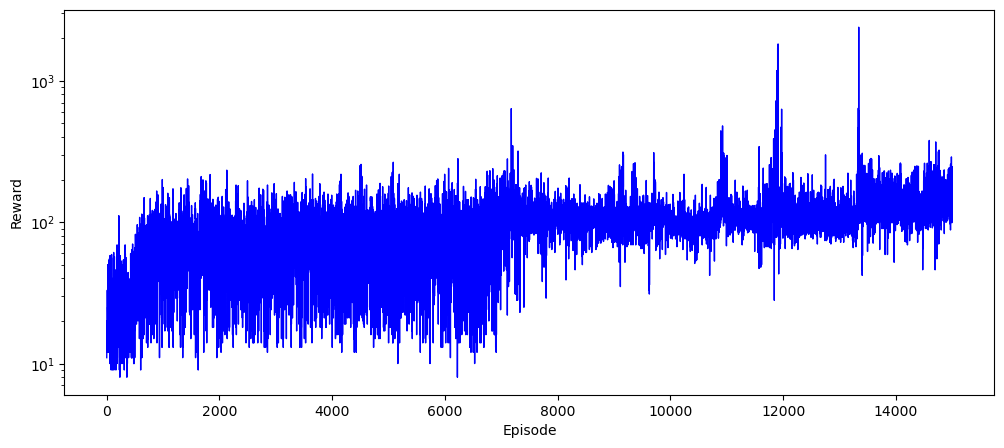

<Figure size 640x480 with 0 Axes>

In [93]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
# plot the figure and adjust the plot parameters
plt.plot(sumRewardsEpisode,color='blue',linewidth=1)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.yscale('log')
plt.show()
plt.savefig('convergence.png')